<div align="center"> 

---

# **Behavioral metrics**

</div>


---

<div align="center"> 

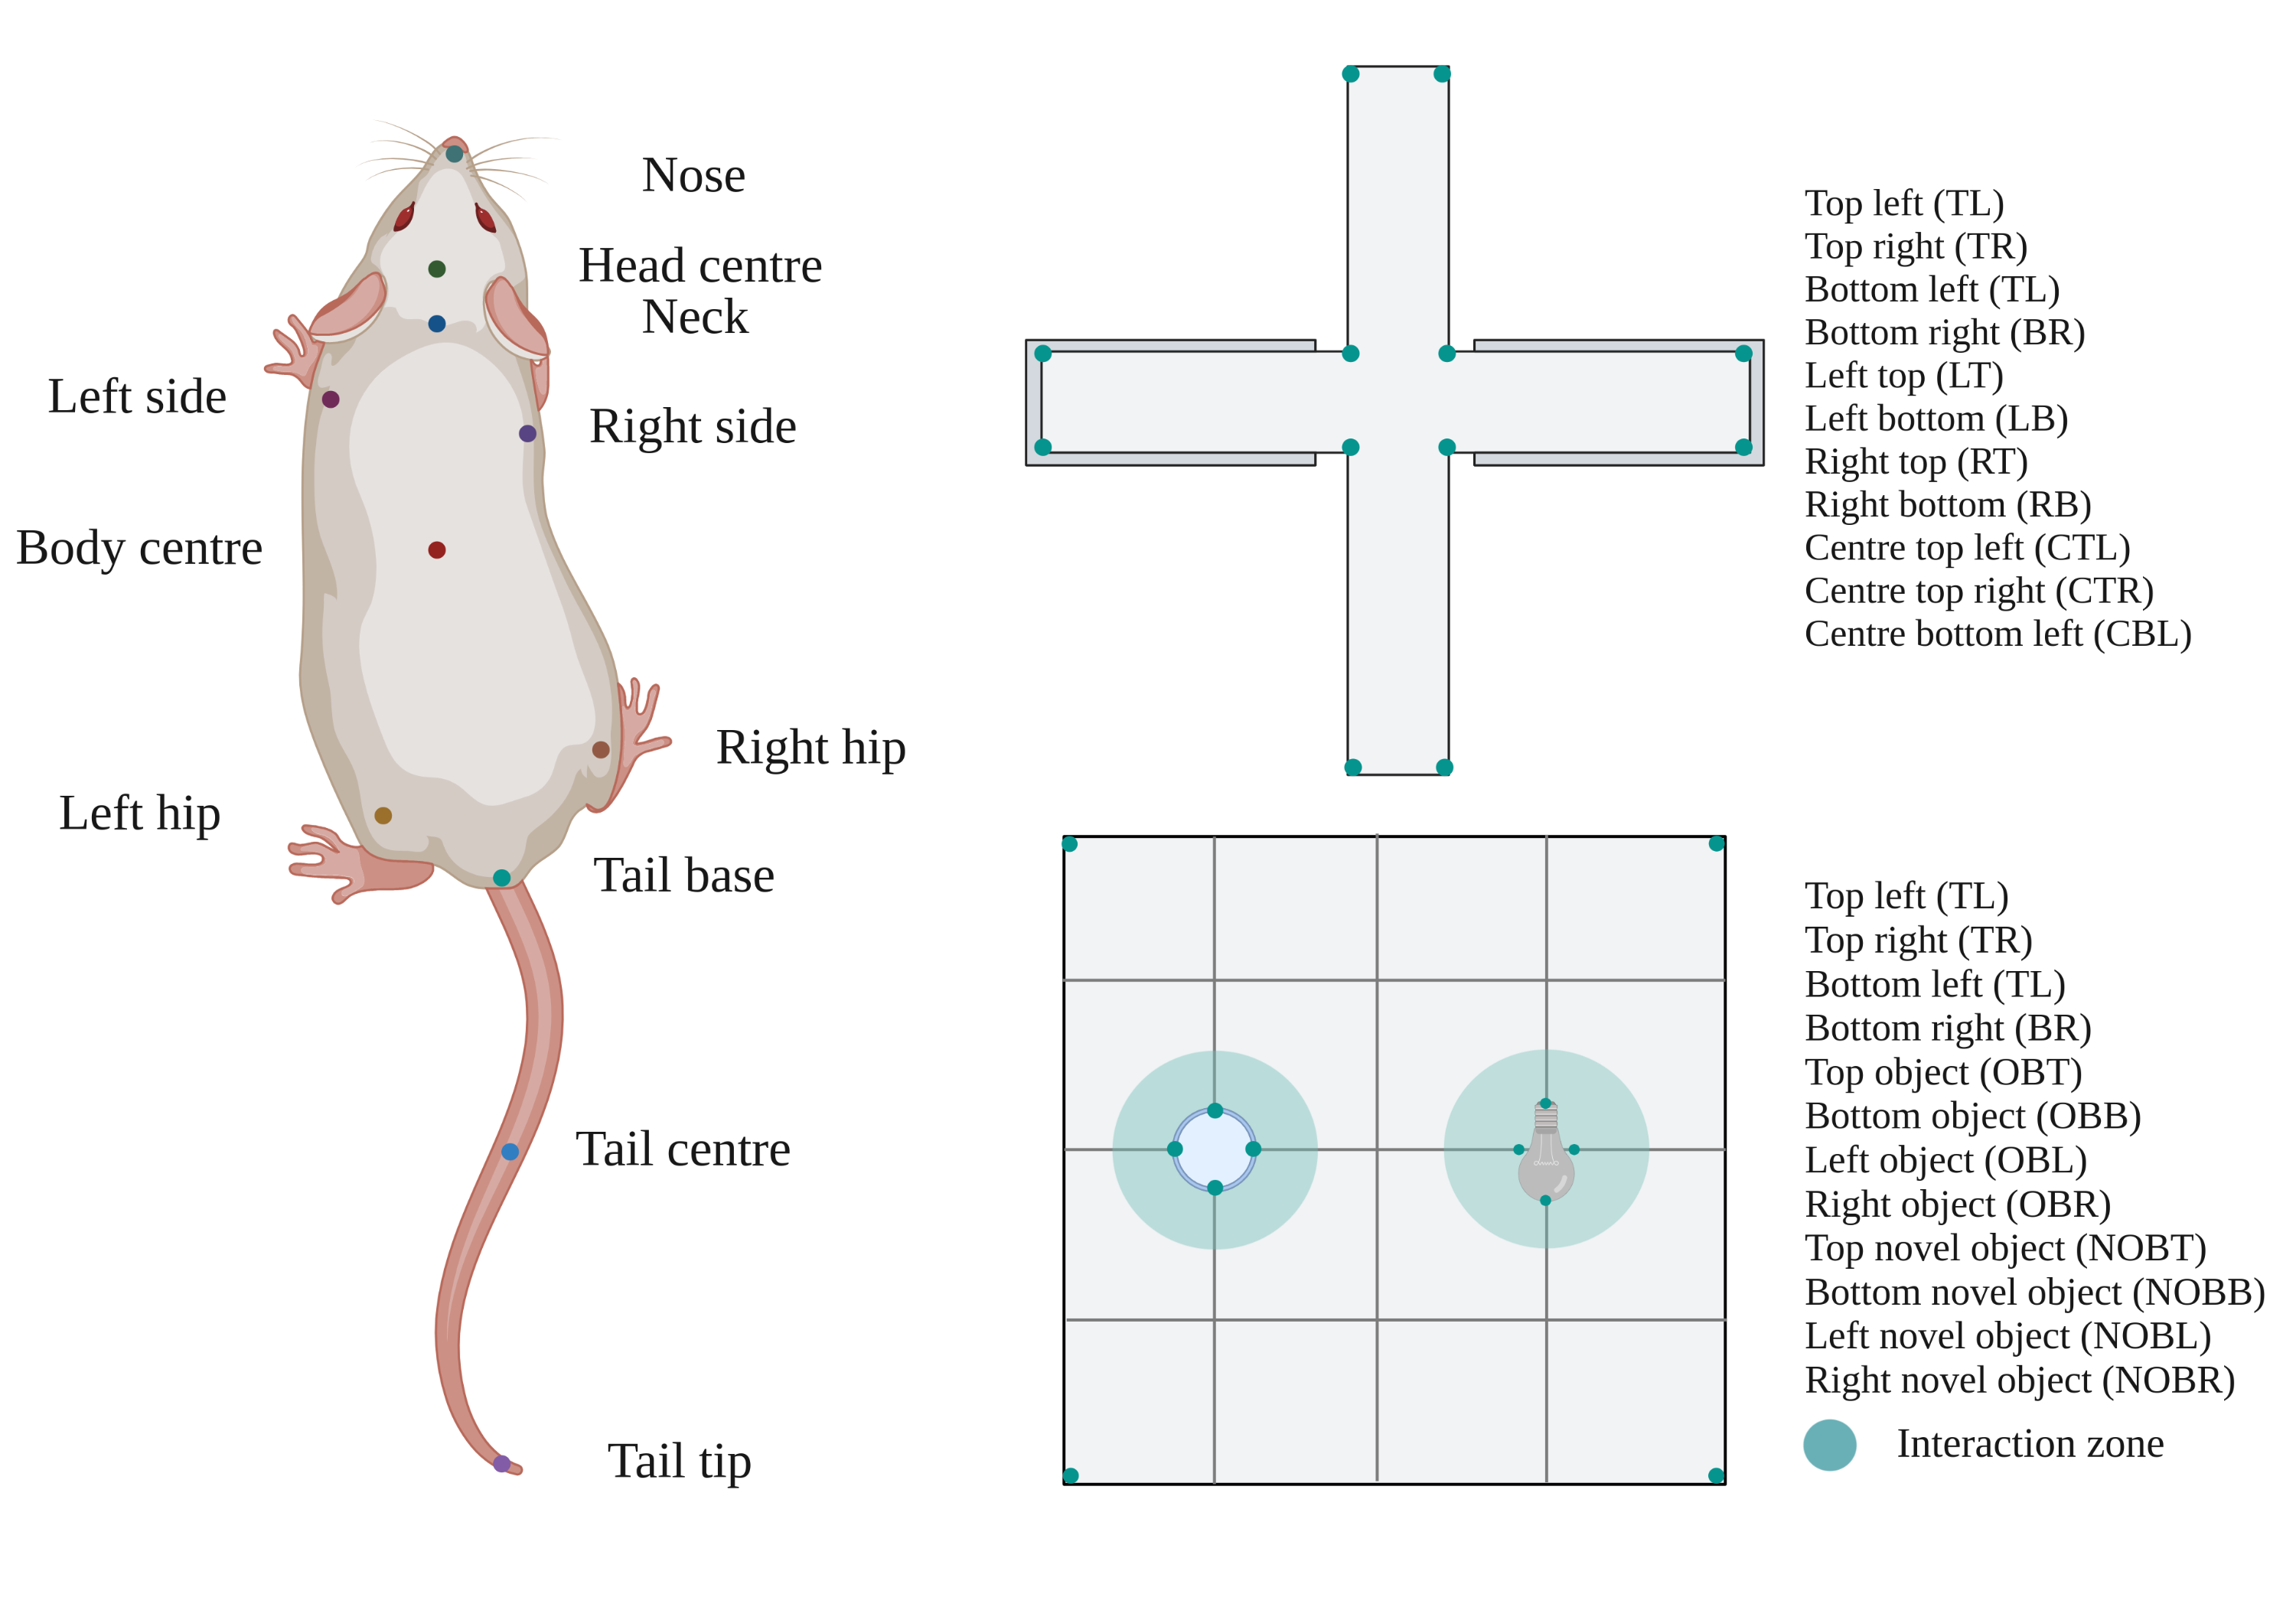

</div>

---
# <u> **Description:**</u>

Behavioral

---

## **Workflow**

0. Deeplabcut code
1. General preparation
2. Data preparation
3. Analysis
4. Exploratory data analysis
5. Visualization
6. Export data

---

**Variables to consider:** 
  - Session
  - Sex  
  
**Tasks:**
  - Elevated plus maze
  - Novel object recognition
  
**Analysis:**
  - 
  - 

---

### **General settings options**

In [1]:
addTaskCallback(function(...) {set.seed(42);TRUE})
options(warn=-1) # to turn off warnings
#options(warn=0) # to turn on warnings
options(repr.plot.width=14, repr.plot.height=10) # to resize plots

2 
2

In [4]:
setwd("../")
load("Data/Alcohol_consumption.RData")

## **0. Deeplabcut code**

The raw and labelled videos can be found in:


We trained a neural network for each behavioral task, the code for running it into a HCP cluster and the options for it are:
  
[bash script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/run_dlc.sh)   
[dlc commands](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/dlc_commands.py)

We created a neural network using the following bodyparts/maze labels:
- tl = top left
- tr = top right
- bl = bottom left
- br = bottom right
- obt = object top
- obb = object bottom
- obl = object left
- obr = object right
- nobt = novel object top
- nobb = novel object bottom
- nobl = novel object left
- nobr = novel object right
- nose
- headcentre
- neck
- bodycentre
- bcl = bodycentre left
- bcr = bodycentre right
- hipl = left hip
- hipr = right hip
- tailbase
- tailcentre
- tailtip

Config files to train the networks:
[Config EPM](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/config_EPM.yaml)   
[Config NOR](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/config_NOR.yaml) 

1. Once we trained the net, we tested for automatic tracking of each rat on each behavioral task
2. We exported the tracking to csv files
3. Using DLCAnalyzer we extracted the metrics of interest (https://www.nature.com/articles/s41386-020-0776-y)
    - EPM: Using the scripts (https://github.com/ETHZ-INS/DLCAnalyzer)
    - NOR: a modified script of DLC [script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLC/DLCAnalyzer_NOR.R)

## **1. General preparation**

### **1.1 Load  R packages and dependencies.** 

  The following packages are needed for the to move on, firstly it is needed to download pacman library

 ---

In [ ]:
# Make sure to install pacman before we begin
  if (!require("pacman")) {
  install.packages("pacman")
  }

# Load required packages  
  pacman::p_load(tidyverse,lme4,devtools,ggpubr,rstatix,ggdist,sp,imputeTS,ggmap,data.table,cowplot,corrplot,keras,magrittr,gghalves,skimr,emmeans,multcomp)


In [5]:
# Run DLCAnalyzer scripts
source("code/DLC/DLCAnalyzer_NOR.R")

### **1.1 Files**

For EPM, the files are: 

- EPM: T1 and T2: {Batch}_EPM_{RID}_{Time}DLC_resnet50_EPMMar18shuffle1_{train_cycle}

For NOR, the files are:
- NOR: T1 and T2: {Batch}_{RID}_{Phase}DLC_resnet50_ORApr27shuffle1_{train_cycle}

---

---

# **Elevated plus maze**

---

## **2. Data preparation**

Reading files and set it all up.

Firstly, run the functions made by Sturman et al, (2020) and the modified function for NOR, the script is in:

[script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLCAnalyzer_NOR.R)

Secondly, create the function to read, calibrating and analysis of the tracking accordingly with each batch recording (camera parameters)

Frames per second (fps):
- Batch 1: 7.5 and 22.5
- Batch 2: 7.5
- Batch 3: 30
- Batch 4: 15
- Batch 5: 15

#### Important: 

The bodycenter is the point-label to consider if the rat is in which arm

In [ ]:
Class_group <- read_csv("Data/Class.csv")

In [ ]:
T1_input_folder <- paste0(getwd(),"/Data/Behavior/EPM/T1/")
T2_input_folder <- paste0(getwd(),"/Data/Behavior/EPM/T2/")
RID_group <- read_csv("Data/RID.csv")

DLCmetrics_selection <- c('file','bodycentre.distance.moving', 'bodycentre.speed.moving', 'bodycentre.time.moving', 'bodycentre.total.time', 
'bodycentre.time.stationary', 'bodycentre.center.distance.moving', 'bodycentre.center.speed.moving',
'bodycentre.center.time.moving', 'bodycentre.center.total.time', 'bodycentre.center.time.stationary',
'bodycentre.center.transitions', 'bodycentre.open.distance.moving', 'bodycentre.open.speed.moving',
'bodycentre.open.time.moving', 'bodycentre.open.total.time', 'bodycentre.open.time.stationary',
'bodycentre.open.transitions', 'bodycentre.closed.distance.moving', 'bodycentre.closed.speed.moving',
'bodycentre.closed.time.moving', 'bodycentre.closed.total.time', 'bodycentre.closed.time.stationary',
'bodycentre.closed.transitions')

In [28]:
RID_group %>% left_join(Class_group[-3], by ="RID") %>% mutate(class = case_when(class == "Low" ~ class, class == "High" ~ class,TRUE ~ "Ctrl")) %>% 
write_csv("Data/RID_Group_class.csv")

### **2.1 Create functions accordingly with each batch**

In [29]:
# Create function ---------------------------------------------------------

pipeline_1 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 22.5)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = "bodycentre", nosedips = FALSE)
  return(Tracking)
}

pipeline_2 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 7.5)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = "bodycentre", nosedips = FALSE)
  return(Tracking)
}

pipeline_3 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 30)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = "bodycentre", nosedips = FALSE)
  return(Tracking)
}

pipeline_45 <- function(path){
  Tracking <- ReadDLCDataFromCSV(file = path, fps = 15)
  Tracking <- CutTrackingData(Tracking,start = 100, end = 250)
  Tracking <- CalibrateTrackingData(Tracking, method = "distance",in.metric = 65.5, points = c("tl","br"))
  zoneinfo <- read.table(paste0(getwd(),"/code/DLC/EPM_zoneinfo.csv"), sep = ",", header = T)
  Tracking <- AddZones(Tracking,zoneinfo)
  Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.8))
  Tracking <- EPMAnalysis(Tracking, movement_cutoff = 5,integration_period = 5,points = "bodycentre", nosedips = FALSE)
  return(Tracking)
}

### **2.2 Analyze tracking with DLC analyzer**

In [ ]:
# Batch 1

### T1 ###
# No recorded

### T2 ###

B1_files_T2 <- list.files(T2_input_folder, pattern = "G1", recursive = T)[-c(7,12)]

B1_TrackingAll_T2 <- RunPipeline(B1_files_T2,T2_input_folder,FUN = pipeline_2)
B15_Report_T2 <- MultiFileReport(B1_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))


# Batch 1.1

### T2 ###
B17_files_T2 <- list.files(T2_input_folder, pattern = "G1_EPM_07") 
B17_TrackingAll_T2 <- RunPipeline(B17_files_T2,T2_input_folder,FUN = pipeline_1)
B17_Report_T2 <- MultiFileReport(B17_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))

B114_files_T2 <- list.files(T2_input_folder, pattern = "G1_EPM_14") 
B114_TrackingAll_T2 <- RunPipeline(B114_files_T2,T2_input_folder,FUN = pipeline_1)
B114_Report_T2 <- MultiFileReport(B114_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))

B1_Report_T2 <- rbind.data.frame(B15_Report_T2,B17_Report_T2,B114_Report_T2)

In [ ]:
# Batch 2

### T1 ###

B2_files_T1 <- list.files(T1_input_folder, pattern = "G2", recursive = T)

B2_TrackingAll_T1 <- RunPipeline(B2_files_T1,T1_input_folder,FUN = pipeline_2)
B2_Report_T1 <- MultiFileReport(B2_TrackingAll_T1) %>% dplyr::select(all_of(DLCmetrics_selection))

### T2 ###

B2_files_T2 <- list.files(T2_input_folder, pattern = "G2", recursive = T)

B2_TrackingAll_T2 <- RunPipeline(B2_files_T2,T2_input_folder,FUN = pipeline_2)
B2_Report_T2 <- MultiFileReport(B2_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))
    

In [ ]:
# Batch 3

### T1 ###

B3_files_T1 <- list.files(T1_input_folder, pattern = "G3", recursive = T)

B3_TrackingAll_T1 <- RunPipeline(B3_files_T1,T1_input_folder,FUN = pipeline_3)
B3_Report_T1 <- MultiFileReport(B3_TrackingAll_T1) %>% dplyr::select(all_of(DLCmetrics_selection))

### T2 ###

B3_files_T2 <- list.files(T2_input_folder, pattern = "G3", recursive = T)

B3_TrackingAll_T2 <- RunPipeline(B3_files_T2,T2_input_folder,FUN = pipeline_3)
B3_Report_T2 <- MultiFileReport(B3_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))
    

In [ ]:
# Batch 4 and 5

### T1 ###

B45_files_T1 <- list.files(T1_input_folder, pattern = "G[4,5]", recursive = T)

B45_TrackingAll_T1 <- RunPipeline(B45_files_T1,T1_input_folder,FUN = pipeline_45)
B45_Report_T1 <- MultiFileReport(B45_TrackingAll_T1) %>% dplyr::select(all_of(DLCmetrics_selection))

### T2 ###

B45_files_T2 <- list.files(T2_input_folder, pattern = "G[4,5]", recursive = T)

B45_TrackingAll_T2 <- RunPipeline(B45_files_T2,T2_input_folder,FUN = pipeline_45)
B45_Report_T2 <- MultiFileReport(B45_TrackingAll_T2) %>% dplyr::select(all_of(DLCmetrics_selection))
    

### **2.3 Binding and arranging**

In [ ]:
Report_T1 <- rbind.data.frame(B2_Report_T1,B3_Report_T1,B45_Report_T1) 
Report_T1 <- Report_T1 %>% 
             add_column(RID = paste0("sub-0", str_split(Report_T1$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))) ,.before = 1) %>% 
             left_join(RID_group, by = "RID") %>% add_column(Stage = rep("T1",length(Report_T1$file)) )

Report_T2 <- rbind.data.frame(B1_Report_T2,B2_Report_T2,B3_Report_T2,B45_Report_T2) 
Report_T2 <- Report_T2 %>% 
             add_column(RID = paste0("sub-0", str_split(Report_T2$file,n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(3))) ,.before = 1) %>% 
             left_join(RID_group, by = "RID") %>% add_column(Stage = rep("T2",length(Report_T2$file)) )

Report_DLC <- rbind.data.frame(Report_T1,Report_T2) %>% full_join(read_csv("Data/Behavior/EPM/T1/LEC_B1.csv"),
                         by = c("RID","Group","Batch","Sex","Stage","bodycentre.center.total.time","bodycentre.open.total.time",
                                "bodycentre.closed.total.time"))

## **3. Analysis**

### **3.1 Time in each arms**

In [39]:
EPM_timeArms <- Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,Stage,bodycentre.open.total.time, bodycentre.closed.total.time) %>%
                pivot_longer(cols = c(bodycentre.open.total.time, bodycentre.closed.total.time), 
                             names_to = "Arm", values_to = "Time") %>%
                filter(Group == "Alc" | Group == "Ctrl") %>% ## Filtering by groups of interest  
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc")),
                RID = factor(RID),
                Stage = factor(Stage),
                Arm = factor(Arm),
                Sex = factor(Sex),
                Arm = case_when(Arm == "bodycentre.open.total.time" ~ "Open",
                                Arm == "bodycentre.closed.total.time" ~ "Closed")) %>% 
                pivot_wider(names_from = Arm, values_from = Time) %>% 
                mutate(resta = (Closed-Open),
                       suma = (Open+Closed),
                       PI = Closed/suma) %>% na.omit() 

### **3.2 Entries in each arms**

In [40]:
EPM_entries <- Report_DLC %>% dplyr::select(RID,Group,Batch,Sex,Stage,bodycentre.open.transitions, bodycentre.closed.transitions) %>%
                pivot_longer(cols = c(bodycentre.open.transitions, bodycentre.closed.transitions), 
                             names_to = "Arm_entries", values_to = "Entries") %>%
                filter(Group == "Alc" | Group == "Ctrl") %>% ## Filtering by groups of interest  
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc")),
                RID = factor(RID),
                Stage = factor(Stage),
                Arm_entries = factor(Arm_entries),
                Sex = factor(Sex),
                Arm_entries = case_when(Arm_entries == "bodycentre.open.transitions" ~ "Open_entries",
                                        Arm_entries == "bodycentre.closed.transitions" ~ "Closed_entries")) %>% 
                pivot_wider(names_from = Arm_entries, values_from = Entries) %>% 
                mutate(resta_entries = (Closed_entries-Open_entries),
                       suma_entries = (Open_entries+Closed_entries),
                       PI_entries = Closed_entries/suma_entries) %>% na.omit() 

### **3.3 Anxiety index**

Anxiety Index = 1 − ([Open arm time/Test duration] + [Open arms entries/Total number of entries]/2)

In [ ]:
EPM_AI <- left_join(EPM_timeArms,EPM_entries) %>% mutate(Anxiety_index = (1 - ( ((Open / suma) + (Open_entries / suma_entries)) / 2 ) ) ) %>% 
          left_join(Class_group) %>% convert_as_factor(Sex,Group)

In [42]:
EPM_AI$class <- EPM_AI$class %>% replace_na('Ctrl')

## **4. Exploratory data analysis**

In [44]:
EPM_AI %>% skimr::skim()

,skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,factor.ordered,factor.n_unique,factor.top_counts,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<lgl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,character,RID,0,1.0000000,7,7,0,52,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,character,Batch,0,1.0000000,2,2,0,5,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,character,class,0,1.0000000,3,4,0,3,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,factor,Group,0,1.0000000,NA,NA,NA,NA,NA,FALSE,2,"Alc: 64, Ctr: 38",NA,NA,NA,NA,NA,NA,NA,NA
5,factor,Sex,0,1.0000000,NA,NA,NA,NA,NA,FALSE,2,"fem: 53, mal: 49",NA,NA,NA,NA,NA,NA,NA,NA
6,factor,Stage,0,1.0000000,NA,NA,NA,NA,NA,FALSE,2,"T2: 52, T1: 50",NA,NA,NA,NA,NA,NA,NA,NA
7,numeric,Open,0,1.0000000,NA,NA,NA,NA,NA,NA,NA,NA,172.0030283,140.0106278,34.5700,88.9833333,144.8683333,197.2166667,842.5333333,▇▂▁▁▁
8,numeric,Closed,0,1.0000000,NA,NA,NA,NA,NA,NA,NA,NA,93.1839216,92.5597889,0.0000,32.7361111,70.4000000,124.7583333,581.7333333,▇▂▁▁▁
9,numeric,resta,0,1.0000000,NA,NA,NA,NA,NA,NA,NA,NA,-78.8191068,157.1814362,-835.0667,-159.1916667,-72.8000000,25.8416667,347.3333333,▁▁▅▇▁


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             102       
Number of columns          17        
_______________________              
Column type frequency:               
  character                3         
  factor                   3         
  numeric                  11        
________________________             
Group variables            None      

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 RID                   0             1   7   7     0       52          0
2 Batch                 0             1   2   2     0        5          0
3 class                 0             1   3   4     0        3          0

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique top_counts      
1 Group

In [45]:
EPM_AI %>% group_by(Group,Sex) %>% identify_outliers(Anxiety_index)

Group,Sex,RID,Batch,Stage,Open,Closed,resta,suma,PI,Open_entries,Closed_entries,resta_entries,suma_entries,PI_entries,Anxiety_index,class,is.outlier,is.extreme
<fct>,<fct>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
Ctrl,male,sub-087,B5,T1,43.6,178,134.4,221.6,0.8032491,15,27,12,42,0.6428571,0.7230531,Ctrl,TRUE,FALSE


### **4.1 Stats (hyphotesis testing)**

In [46]:
EPM.aov <- anova_test(data = EPM_AI, dv = Anxiety_index, wid = RID,
                               between = c(Group,Sex), within = Stage)
EPM.aov

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,1,36,1.074,0.307,,2.00e-02
2,Sex,1,36,11.877,0.001,*,1.82e-01
3,Stage,1,36,0.172,0.681,,2.00e-03
4,Group:Sex,1,36,0.160,0.692,,3.00e-03
5,Group:Stage,1,36,0.039,0.844,,3.55e-04
6,Sex:Stage,1,36,0.834,0.367,,8.00e-03
7,Group:Sex:Stage,1,36,0.004,0.951,,3.47e-05


In [47]:
EPM.t <- EPM_AI %>%
  group_by(Group,Sex) %>%
  pairwise_t_test(
    Anxiety_index ~ Stage, paired = FALSE, 
    p.adjust.method = "fdr")

In [48]:
EPM.aov_class <- anova_test(data = EPM_AI, dv = Anxiety_index, wid = RID,
                               between = c(class,Sex), within = Stage)
EPM.aov_class

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,class,2,34,1.558,0.225,,0.061
2,Sex,1,34,6.257,0.017,*,0.116
3,Stage,1,34,0.352,0.557,,0.003
4,class:Sex,2,34,0.550,0.582,,0.022
5,class:Stage,2,34,0.838,0.441,,0.014
6,Sex:Stage,1,34,5.913,0.020,*,0.048
7,class:Sex:Stage,2,34,4.502,0.018,*,0.071


In [49]:
EPM.t_class <- EPM_AI %>%
  group_by(class,Sex) %>%
  pairwise_t_test(
    Anxiety_index ~ Stage, 
    p.adjust.method = "fdr")

In [50]:
EPM.t_class <- EPM_AI %>%
  group_by(Stage,Sex) %>%
  pairwise_t_test(
    Anxiety_index ~ class, 
    p.adjust.method = "fdr")

### **4.1 Stats (Linear modelling)**

In [51]:
Model_AI <- glmer(formula = Group ~ Anxiety_index+Sex+Batch+(1|RID), data = EPM_AI, family = "binomial")

In [52]:
Model_AI <- lmer(formula = Anxiety_index ~ Group*Sex*Stage+Batch+(1|RID), data = EPM_AI)
Model_AI_Intake <- lmer(formula = Anxiety_index ~ class*Sex*Stage+Batch+(1|RID), data = EPM_AI)

In [53]:
summary(Model_AI)

Linear mixed model fit by REML ['lmerMod']
Formula: Anxiety_index ~ Group * Sex * Stage + Batch + (1 | RID)
   Data: EPM_AI

REML criterion at convergence: -20.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.07741 -0.54141 -0.00313  0.49229  2.27335 

Random effects:
 Groups   Name        Variance Std.Dev.
 RID      (Intercept) 0.008728 0.09342 
 Residual             0.024317 0.15594 
Number of obs: 92, groups:  RID, 52

Fixed effects:
                         Estimate Std. Error t value
(Intercept)               0.49471    0.09186   5.386
GroupAlc                 -0.01083    0.08482  -0.128
Sexmale                  -0.13323    0.09338  -1.427
StageT2                   0.04922    0.07933   0.620
BatchB2                  -0.08374    0.07444  -1.125
BatchB3                  -0.04956    0.07158  -0.692
BatchB4                   0.03357    0.07957   0.422
BatchB5                   0.09268    0.07969   1.163
GroupAlc:Sexmale         -0.02764    0.11815  -0.234
GroupAl

In [54]:
emmeans_AI <- emmeans(Model_AI, specs = pairwise ~ Group*Sex*Stage, adjust="fdr")
emmeans_AI$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,estimate,SE,df,t.ratio,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl female T1 - Alc male T2,0.2315757,0.08500612,78.39971,2.724223,0.037071037,*
Alc female T1 - Alc male T2,0.2207487,0.06991999,77.65718,3.157161,0.021174577,*
Alc male T1 - Ctrl female T2,-0.2209106,0.07925367,76.64103,-2.787386,0.037071037,*
Ctrl female T2 - Ctrl male T2,0.2410622,0.08161058,74.02259,2.953811,0.029437755,*
Ctrl female T2 - Alc male T2,0.2807943,0.07504318,73.43027,3.741770,0.007959224,**
Alc female T2 - Ctrl male T2,0.1946014,0.07309749,73.95506,2.662218,0.038075394,*
Alc female T2 - Alc male T2,0.2343335,0.06503450,73.53281,3.603218,0.007959224,**


In [55]:
summary(Model_AI_Intake)


Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML ['lmerMod']
Formula: Anxiety_index ~ class * Sex * Stage + Batch + (1 | RID)
   Data: EPM_AI

REML criterion at convergence: -23.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.50770 -0.52470 -0.03753  0.46710  2.43868 

Random effects:
 Groups   Name        Variance Std.Dev.
 RID      (Intercept) 0.009715 0.09856 
 Residual             0.020253 0.14231 
Number of obs: 92, groups:  RID, 52

Fixed effects:
                          Estimate Std. Error t value
(Intercept)                0.49239    0.08679   5.673
classHigh                 -0.36649    0.13779  -2.660
classLow                   0.05678    0.08330   0.682
Sexmale                   -0.13399    0.08853  -1.513
StageT2                    0.04948    0.07271   0.680
BatchB2                   -0.07604    0.07136  -1.066
BatchB3                   -0.06362    0.06916  -0.920
BatchB4                    0.05545    0.07673   0.723
BatchB5                    0.08747    0.07739   1.1

In [56]:
emmeans_AI_Intake <- emmeans(Model_AI_Intake, specs = pairwise ~ class*Sex*Stage, adjust="fdr")
emmeans_AI_Intake$contrasts %>% as_tibble() %>% filter(p.value < 0.05) %>% add_significance()

contrast,estimate,SE,df,t.ratio,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl female T1 - High female T1,0.3664853,0.13889744,74.59831,2.638531,0.041197655,*
Ctrl female T1 - High male T2,0.3325915,0.10139844,71.95696,3.280046,0.022512123,*
High female T1 - Low female T1,-0.4232628,0.13479927,74.38175,-3.139949,0.024374696,*
High female T1 - Ctrl female T2,-0.4159659,0.13473137,74.29775,-3.087372,0.024374696,*
High female T1 - High female T2,-0.3739021,0.13570686,41.20643,-2.755219,0.041197655,*
High female T1 - Low female T2,-0.3708744,0.13262575,74.35780,-2.796398,0.036153983,*
Low female T1 - Low male T1,0.2286893,0.08166210,72.38873,2.800433,0.036153983,*
Low female T1 - Ctrl male T2,0.2469534,0.07571652,70.86330,3.261552,0.022512123,*
Low female T1 - High male T2,0.3893691,0.09386377,70.58555,4.148236,0.004722982,**


## **5. Visualization**


In [58]:
Plot_EPM_timeArms <- EPM_AI %>%
  ggplot(aes(x = Stage,y = PI, 
             fill = Group)) +
  stat_halfeye(position = "dodge",
               adjust = .9, width = .7) +
  xlab("Stage") + ylab("Preference index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18),
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") + theme_settings

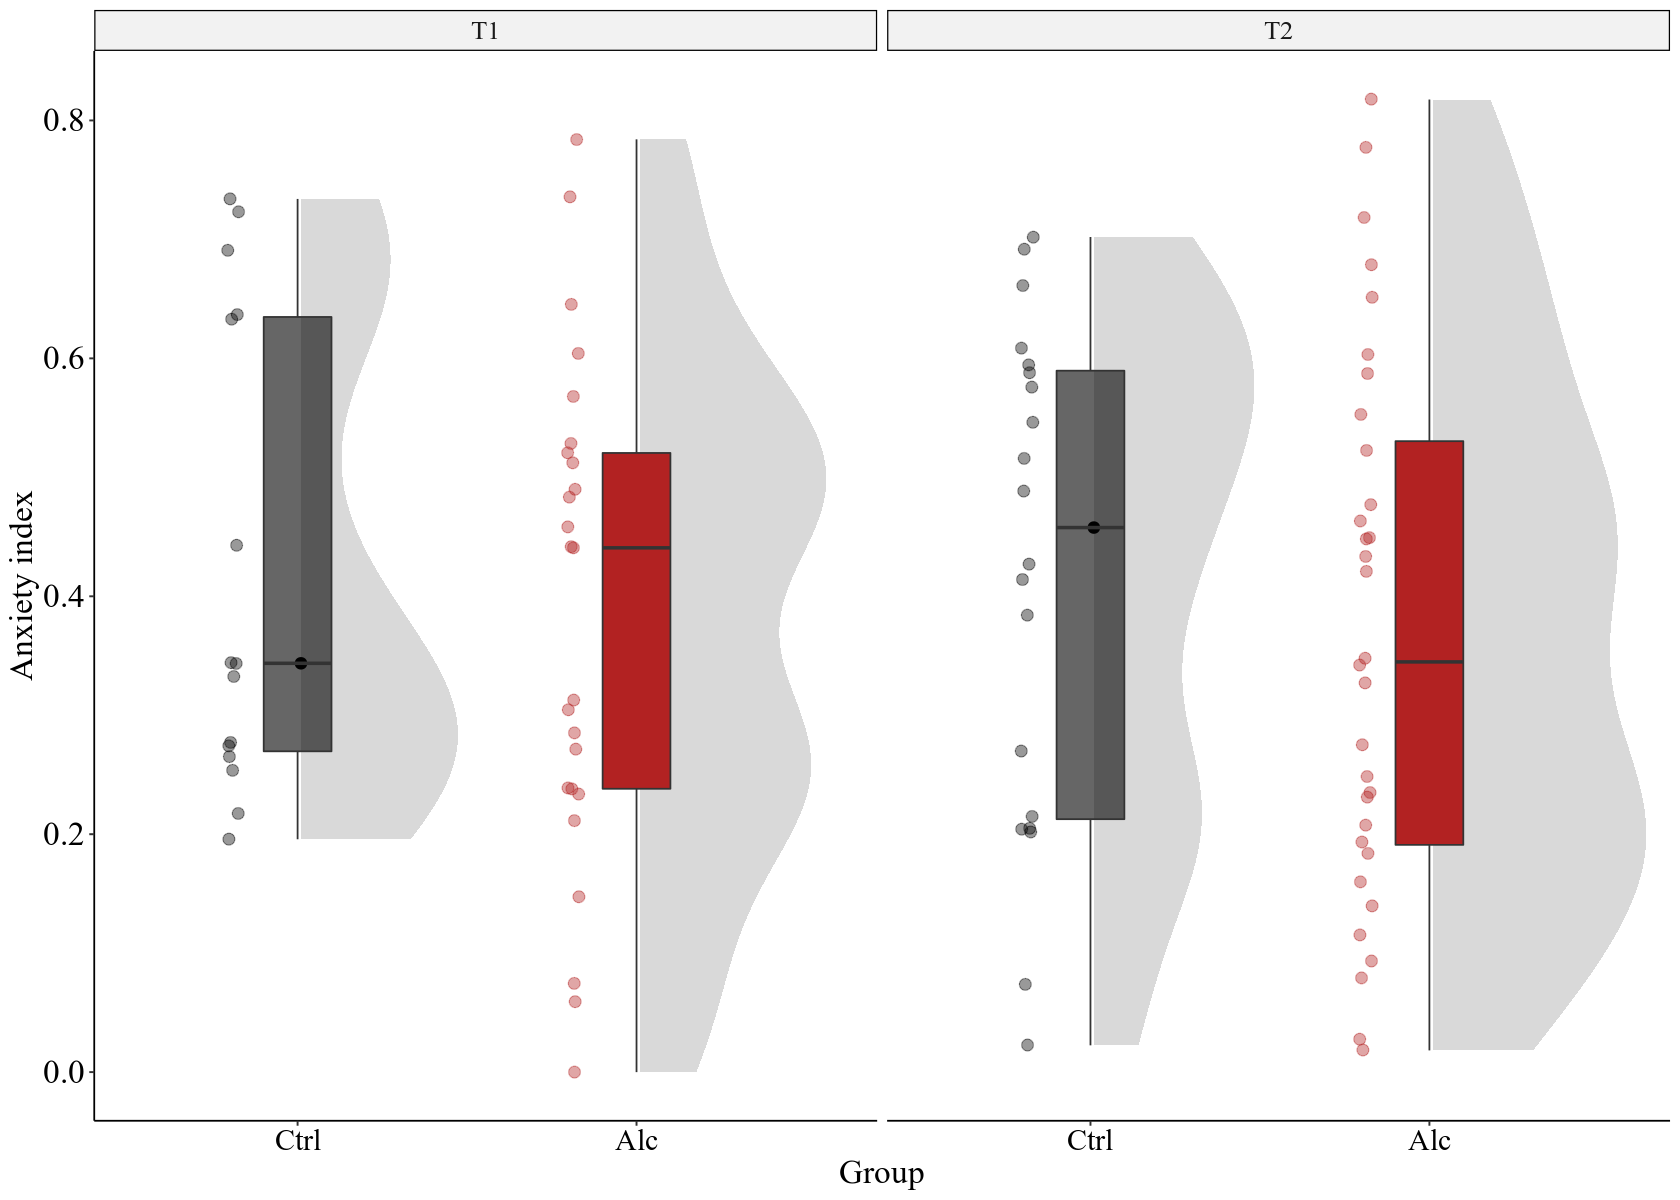

In [59]:
Plot_EPM.AI <- EPM_AI %>% 
  ggplot(aes(x = Group,y = Anxiety_index, 
             fill = Group)) + facet_grid(. ~ Stage) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = Group, fill = Group),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme_settings + 
  stat_compare_means(aes(label = ..p.signif..),method = "t.test",
                     label.x = 1.5, hide.ns = TRUE) + 
  theme(legend.position = "none")
Plot_EPM.AI

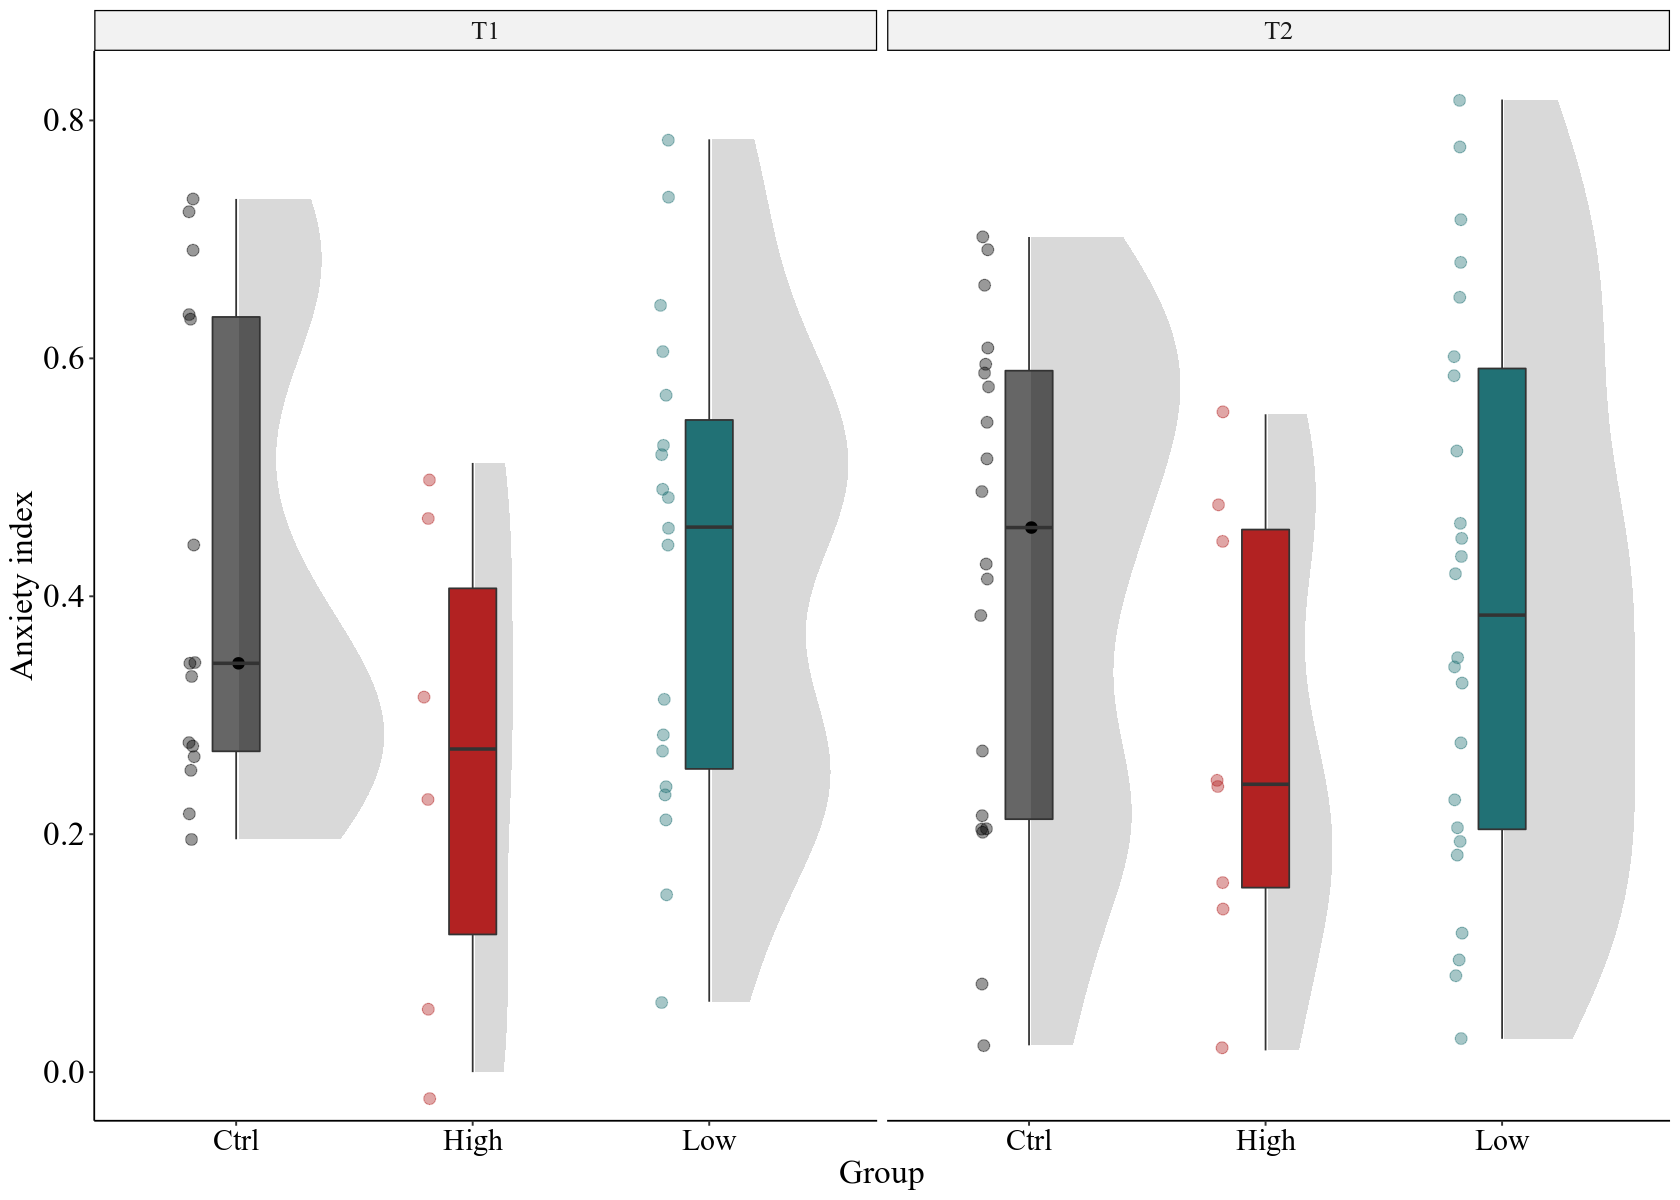

In [60]:
Plot_EPM.AI_class <- EPM_AI %>%
  ggplot(aes(x = class,y = Anxiety_index, 
             fill = class)) + facet_grid(. ~ Stage) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = class, fill = class),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme(legend.position = "none") +
  stat_compare_means(aes(label = after_stat(p.signif)), 
                  method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) + 
  theme_settings
Plot_EPM.AI_class

### 5.1 Visualization by sex but only Behavior T2 stage

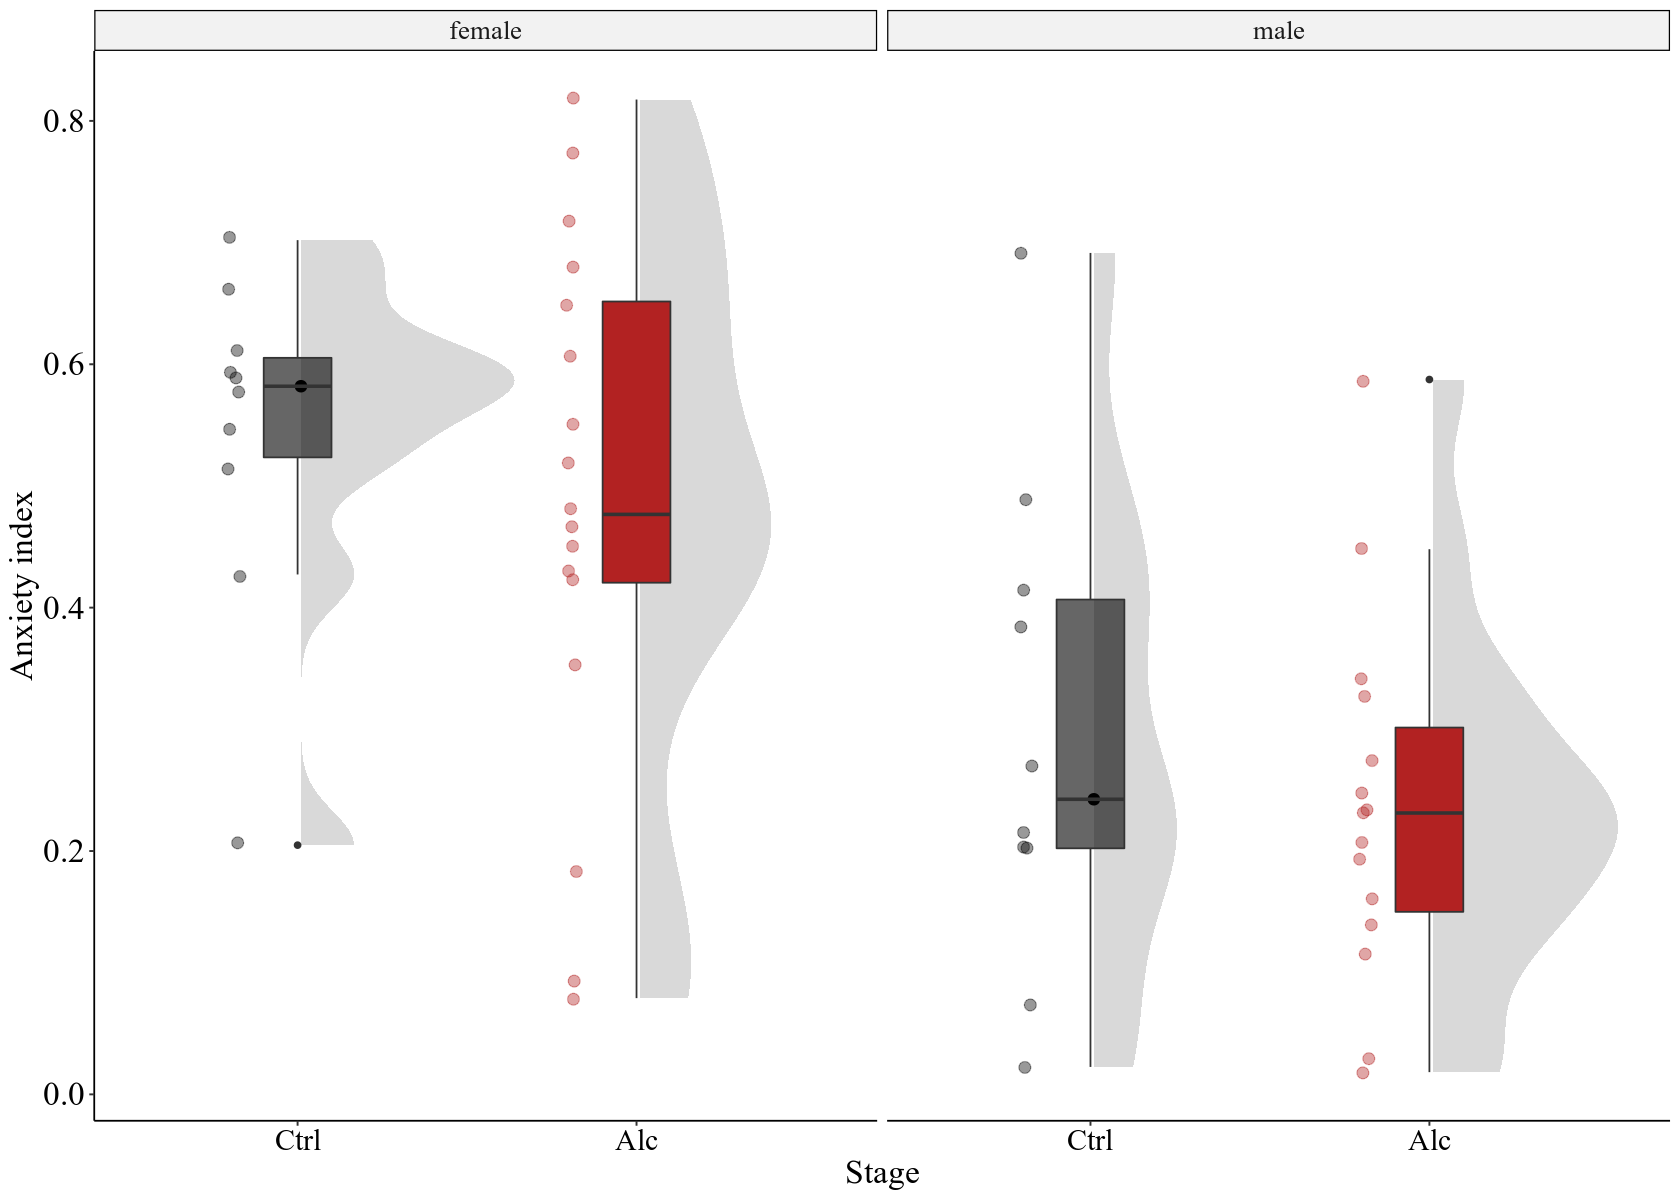

In [61]:
Sex.Plot_EPM.AI <- EPM_AI %>% filter(Stage == "T2") %>%
  ggplot(aes(x = Group,y = Anxiety_index, 
             fill = Group)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Stage") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = Group, fill = Group),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme(legend.position = "none") +
  stat_compare_means(aes(label = ..p.signif..),
                     label.x = 1.5, hide.ns = TRUE) + 
  theme_settings
Sex.Plot_EPM.AI

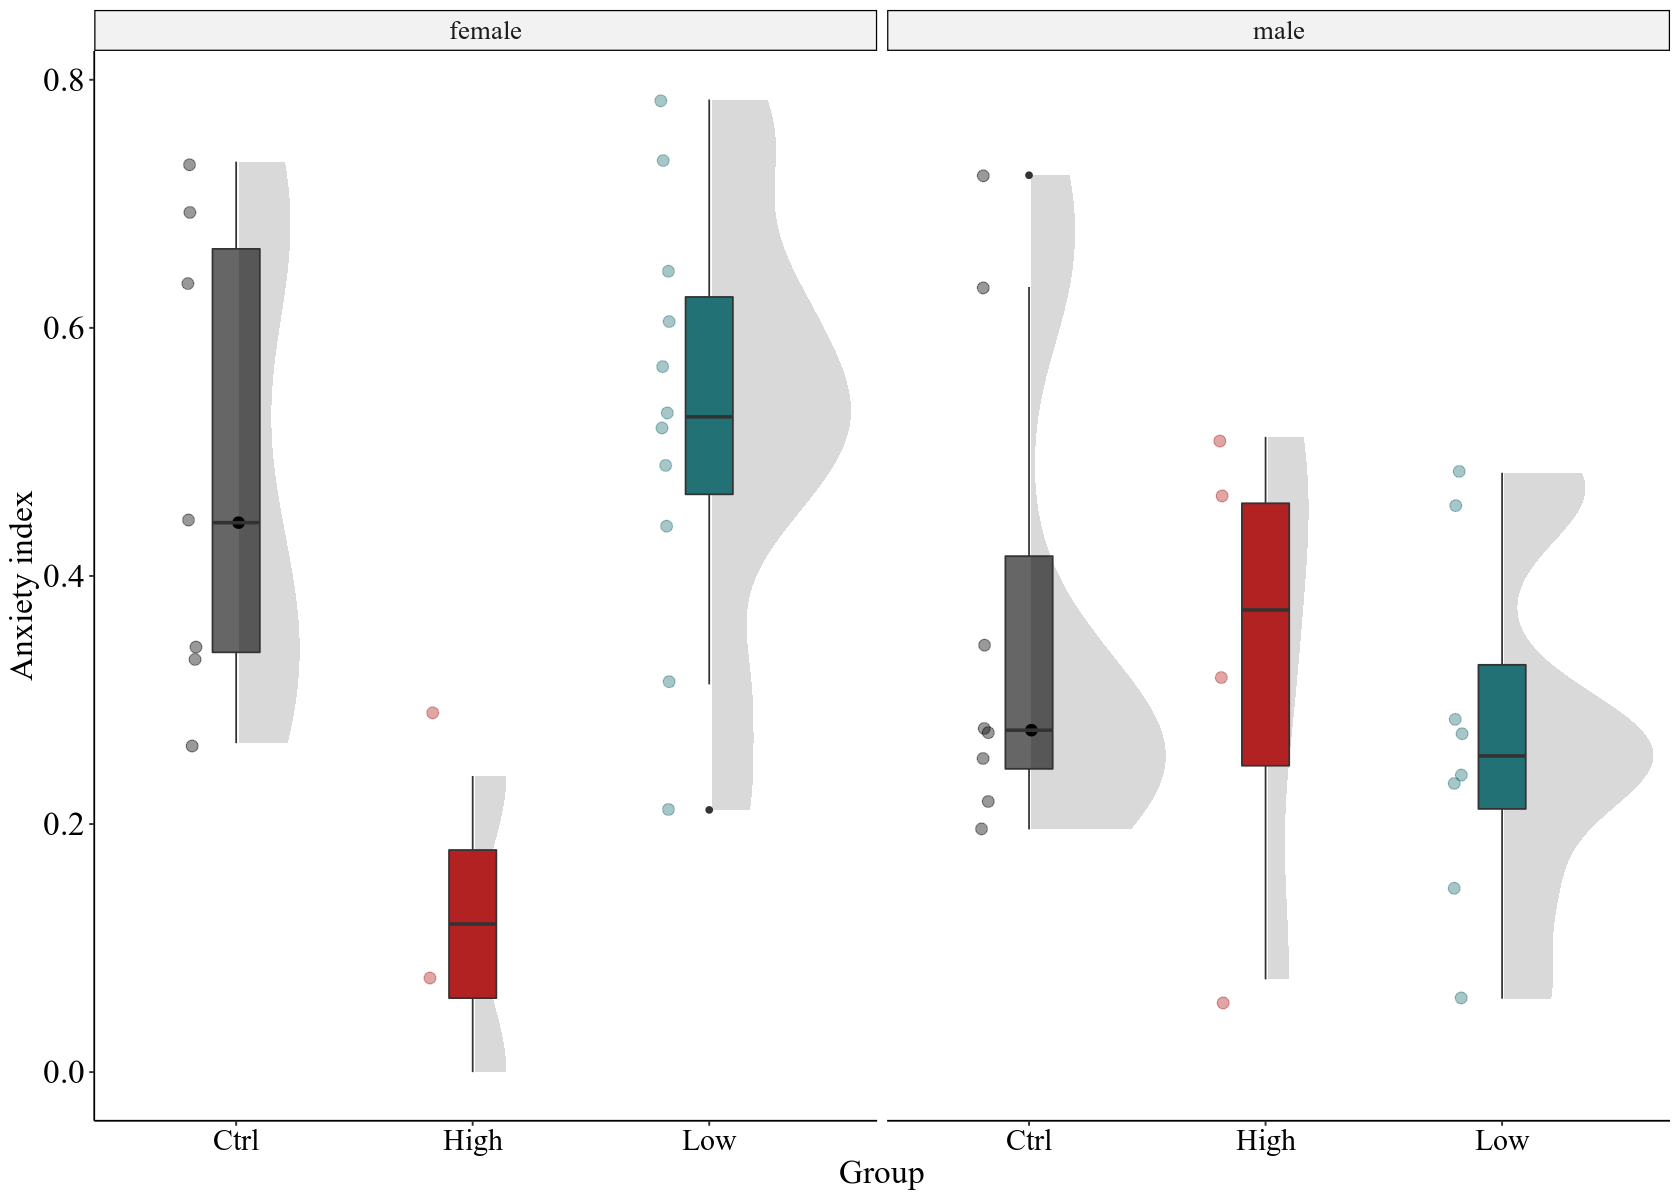

In [62]:
Sex.Plot_EPM.AI_class1 <- EPM_AI %>% filter(Stage == "T1") %>%
  ggplot(aes(x = class,y = Anxiety_index, 
             fill = class)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = class, fill = class),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme(legend.position = "none") +
  theme_settings

Sex.Plot_EPM.AI_class1

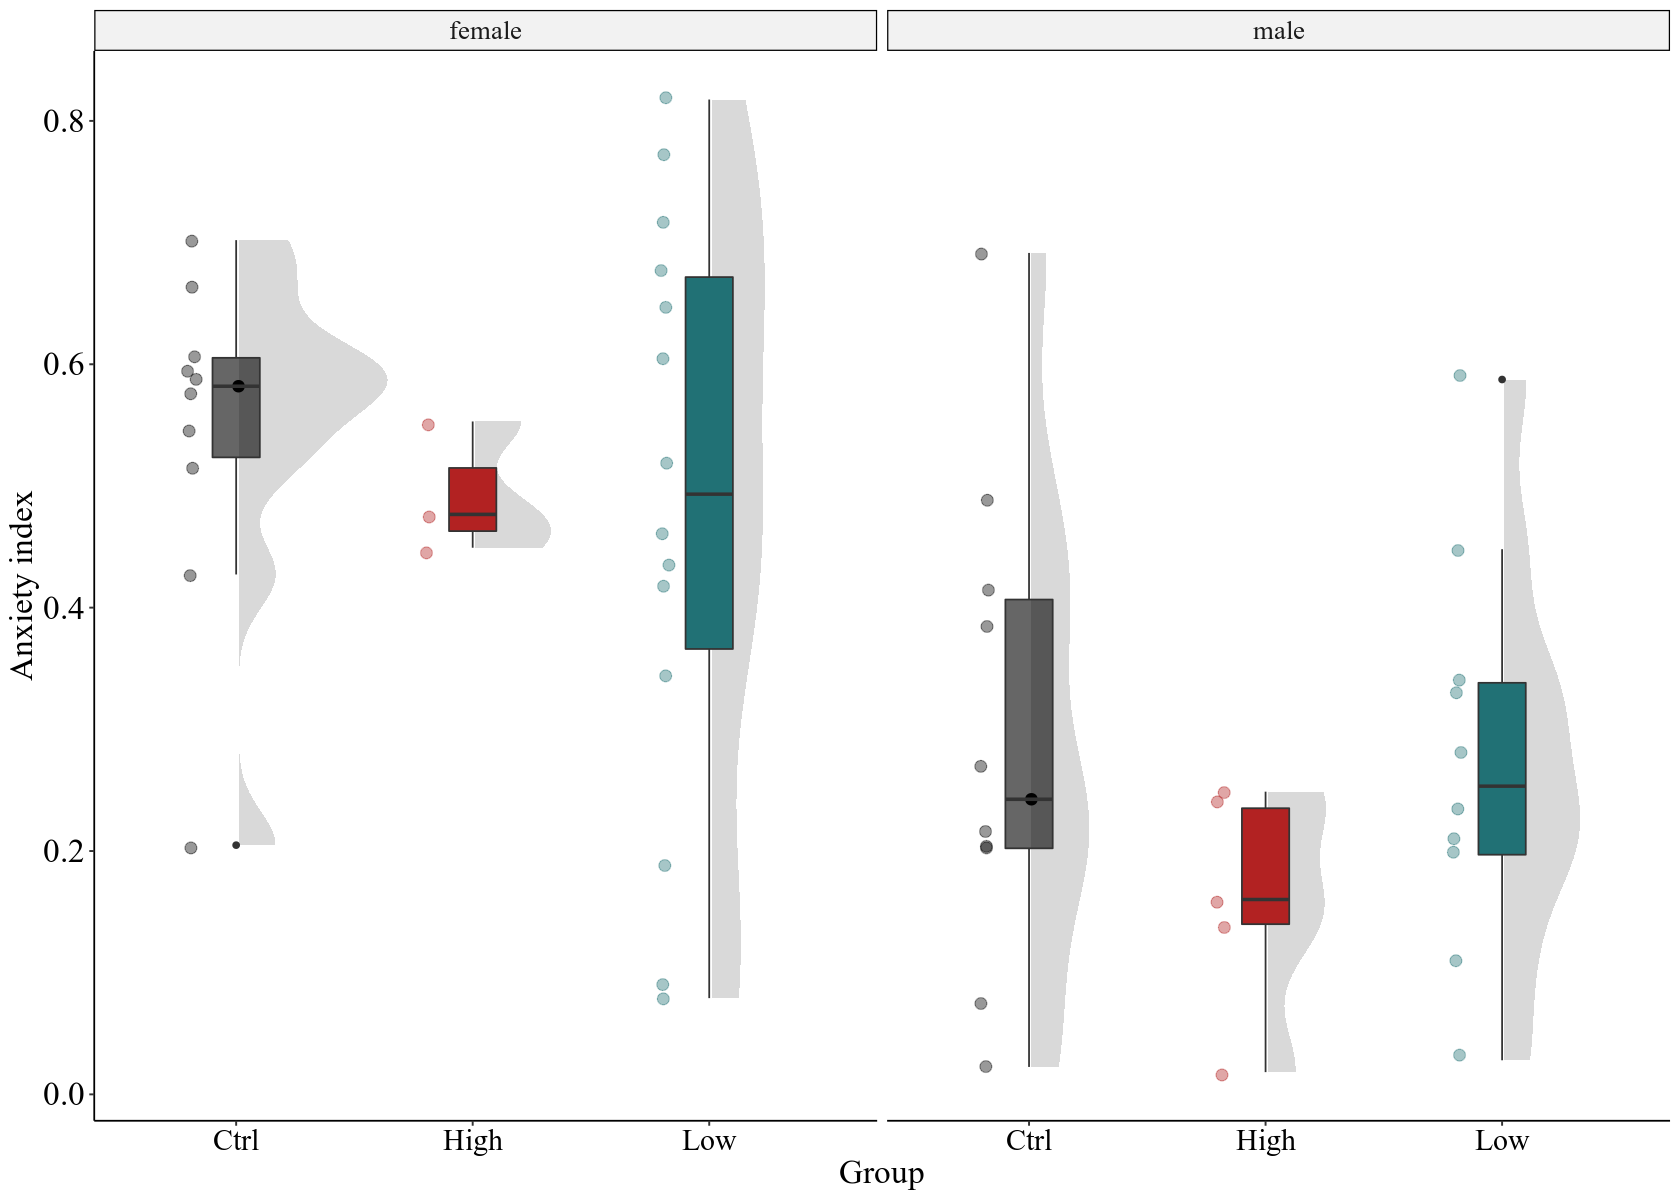

In [64]:
Sex.Plot_EPM.AI_class2 <- EPM_AI %>% filter(Stage == "T2") %>%
  ggplot(aes(x = class,y = Anxiety_index, 
             fill = class)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_half_point(side = "l", aes(color = class, fill = class),
                  range_scale = .1, alpha = .4, size = 3) +
  geom_boxplot(width = .2) +
  theme_pubr() + theme(legend.position = "none") +
  theme_settings

Sex.Plot_EPM.AI_class2

In [65]:
cuca = EPM_AI %>% filter(Stage == "T2") %>%
  group_by(class) %>%
  emmeans_test(Anxiety_index~Sex, p.adjust.method = "fdr") %>%
  add_xy_position( x = "Sex",group = "class", dodge = 0.9) %>% as_tibble()
cuca

class,term,.y.,group1,group2,df,statistic,p,p.adj,p.adj.signif,y.position,groups,xmin,xmax
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<named list>,<dbl>,<dbl>
Ctrl,Sex,Anxiety_index,female,male,46,2.966599,0.004763612,0.004763612,**,0.77028,"female, male",0.7,1.7
High,Sex,Anxiety_index,female,male,46,2.455223,0.017919798,0.017919798,*,0.62128,"female, male",1.0,2.0
Low,Sex,Anxiety_index,female,male,46,2.727417,0.009006158,0.009006158,**,0.88628,"female, male",1.3,2.3


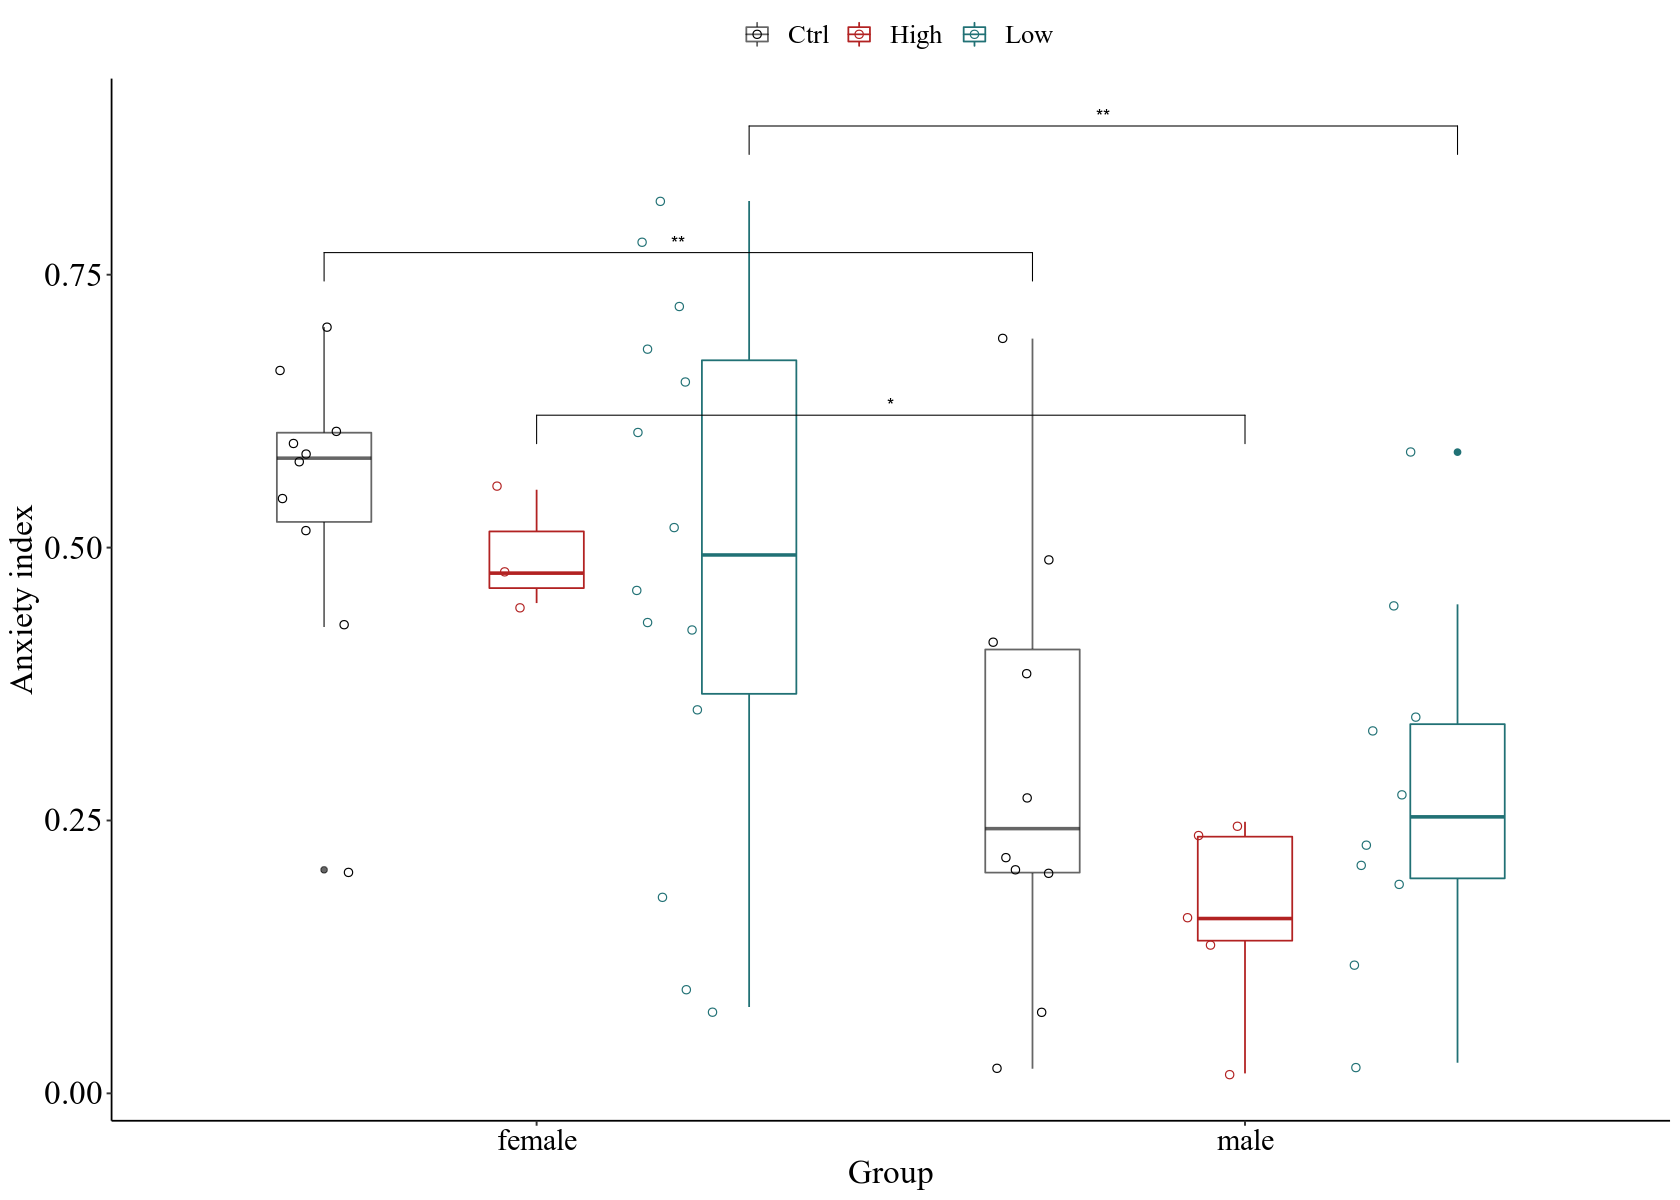

In [66]:
Sex.Plot_EPM.AI_class <- EPM_AI %>% filter(Stage == "T2") %>%
  ggplot(aes(x = Sex,y = Anxiety_index, 
             color = class)) + #facet_grid(. ~ Sex) +
  #stat_halfeye(
  #    adjust = .8, width = .7, fill = "grey85",
  #    interval_colour = NA, 
  #    position = position_nudge(x = .01),
  #    aes(thickness = stat(f*n))) +
  xlab("Group") + ylab("Anxiety index") + 
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) +
  geom_boxplot(width = 0.4,position = position_dodge(width = 0.9)) +
  geom_half_point(side = "l", aes(color = class, fill = class), shape = 1, 
                  range_scale = 1, alpha = 4, size = 2) +
  theme_pubr() + #theme(legend.position = "none") +
  theme_settings

Sex.Plot_EPM.AI_class + stat_pvalue_manual(cuca,hide.ns = F)

## **6. Export data**

In [67]:
dir.create("Figures/EPM")

In [68]:
ggsave(plot = Plot_EPM.AI, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/Plot_EPM_AI.png")

ggsave(plot = Plot_EPM.AI_class, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/Plot_EPM_AI_class.png")

ggsave(plot = Sex.Plot_EPM.AI, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/Sex_Plot_EPM_AI.png")

ggsave(plot = Sex.Plot_EPM.AI_class, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/EPM/Sex_Plot_EPM_AI_class.png")

In [69]:
save(Report_DLC,EPM_AI,Plot_EPM.AI,Plot_EPM.AI_class,Sex.Plot_EPM.AI,Sex.Plot_EPM.AI_class, file = paste0(getwd(),"/Data/Behavior_metricsEPM.RData"))

---
# **Novel object recognition**
---

## **2. Data preparation**

Reading files and set it all up.

Firstly, run the functions made by Sturman et al, (2020) and the modified function for NOR, the script is in:

[script](https://github.com/psilantrolab/Sudmex-alcohol-rat/blob/main/code/DLCAnalyzer_NOR.R)

Secondly, create the function to read, calibrating and analysis of the tracking accordingly with each batch recording (camera parameters)

Frames per second (fps):
- Batch 1: 7.5
- Batch 2: 30
- Batch 3: 7.5
- Batch 4: 7.5
- Batch 5: 16.6

#### Important: 

The nose is the point to consider if the rat is in which object

In [ ]:
NOR_input_folder <- paste0(getwd(),"/Data/Behavior/NOR/NOR/")
OR_input_folder <- paste0(getwd(),"/Data/Behavior/NOR/OR/")
RID_group <- read_csv("Data/RID.csv")
Class_group <- read_csv("Data/Class.csv")

DLCmetrics_selectionNOR <- c('file', 'nose.ob.distance.moving', 'nose.ob.speed.moving','nose.ob.time.moving', 
                             'nose.ob.total.time', 'nose.ob.time.stationary','nose.ob.transitions','nose.nob.distance.moving', 'nose.nob.speed.moving',
                             'nose.nob.time.moving', 'nose.nob.total.time', 'nose.nob.time.stationary','nose.nob.transitions')

### **2.1 Create functions accordingly with each batch**

In [75]:
# Create function ---------------------------------------------------------

ROpipeline_134 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 7.5)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

ROpipeline_2 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 30)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

ROpipeline_5 <- function(path){
    Tracking <- ReadDLCDataFromCSV(file = path, fps = 16.6)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95)
    Tracking <- CalibrateTrackingData(Tracking, "area",in.metric = 42*42, points = c("tl","tr","br","bl"))
    PlotPointData(Tracking, points = c("nose"))
    zoneinfo <- read.table(paste0(getwd(),"/code/DLC/RO.csv"), sep = ";", header = T)
    Tracking <- AddZones(Tracking,zoneinfo)
    Tracking <- objet(Tracking, 7)
    Tracking <- CleanTrackingData(Tracking, likelihoodcutoff = 0.95,existence.pol = ScalePolygon(Tracking$zones$arena, 1.2))
    Tracking <- AnalysisRO(Tracking, movement_cutoff = 4,integration_period = 5,points = "nose", nosedips = FALSE)
    return(Tracking)
  }

### **2.2 Analyze tracking with DLC analyzer**

In [ ]:
# Batch 1

### OR ###
B1_files_OR <- list.files(OR_input_folder, pattern = "G1", recursive = T)
B1_TrackingAll_OR <- RunPipeline(B1_files_OR,OR_input_folder,FUN = ROpipeline_134)
B1_Report_OR <- MultiFileReport(B1_TrackingAll_OR) %>% select(all_of(DLCmetrics_selectionNOR))

### NOR ###

B1_files_NOR <- list.files(NOR_input_folder, pattern = "G1", recursive = T)
B1_TrackingAll_NOR <- RunPipeline(B1_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B1_Report_NOR <- MultiFileReport(B1_TrackingAll_NOR) %>% select(all_of(DLCmetrics_selectionNOR))


In [ ]:
# Batch 2

### OR ###
B2_files_OR <- list.files(OR_input_folder, pattern = "G2", recursive = T)
B2_TrackingAll_OR <- RunPipeline(B2_files_OR,OR_input_folder,FUN = ROpipeline_2)
B2_Report_OR <- MultiFileReport(B2_TrackingAll_OR) %>% select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B2_files_NOR <- list.files(NOR_input_folder, pattern = "G2", recursive = T)
B2_TrackingAll_NOR <- RunPipeline(B2_files_NOR,NOR_input_folder,FUN = ROpipeline_2)
B2_Report_NOR <- MultiFileReport(B2_TrackingAll_NOR) %>% select(all_of(DLCmetrics_selectionNOR))


In [ ]:
# Batch 3

### OR ###
B3_files_OR <- list.files(OR_input_folder, pattern = "G3", recursive = T)
B3_TrackingAll_OR <- RunPipeline(B3_files_OR,OR_input_folder,FUN = ROpipeline_134)
B3_Report_OR <- MultiFileReport(B3_TrackingAll_OR) %>% select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B3_files_NOR <- list.files(NOR_input_folder, pattern = "G3", recursive = T)
B3_TrackingAll_NOR <- RunPipeline(B3_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B3_Report_NOR <- MultiFileReport(B3_TrackingAll_NOR) %>% select(all_of(DLCmetrics_selectionNOR))


In [ ]:
# Batch 4

### OR ###
B4_files_OR <- list.files(OR_input_folder, pattern = "G4", recursive = T)
B4_TrackingAll_OR <- RunPipeline(B4_files_OR,OR_input_folder,FUN = ROpipeline_134)
B4_Report_OR <- MultiFileReport(B4_TrackingAll_OR) %>% select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B4_files_NOR <- list.files(NOR_input_folder, pattern = "G4", recursive = T)
B4_TrackingAll_NOR <- RunPipeline(B4_files_NOR,NOR_input_folder,FUN = ROpipeline_134)
B4_Report_NOR <- MultiFileReport(B4_TrackingAll_NOR) %>% select(all_of(DLCmetrics_selectionNOR))
 

In [ ]:
# Batch 5

### OR ###
B5_files_OR <- list.files(OR_input_folder, pattern = "G5", recursive = T)
B5_TrackingAll_OR <- RunPipeline(B5_files_OR,OR_input_folder,FUN = ROpipeline_5)
B5_Report_OR <- MultiFileReport(B5_TrackingAll_OR) %>% select(all_of(DLCmetrics_selectionNOR))

### NOR ###
B5_files_NOR <- list.files(NOR_input_folder, pattern = "G5", recursive = T)
B5_TrackingAll_NOR <- RunPipeline(B5_files_NOR,NOR_input_folder,FUN = ROpipeline_5)
B5_Report_NOR <- MultiFileReport(B5_TrackingAll_NOR) %>% select(all_of(DLCmetrics_selectionNOR))
 

### **2.3 Binding and arranging**

In [ ]:
Report_OR <- rbind.data.frame(B1_Report_OR,B2_Report_OR,B3_Report_OR,B4_Report_OR,B5_Report_OR)
Report_OR <- Report_OR %>% 
             add_column(RID = paste0("sub-", str_split(Report_OR$file, n = 4, pattern = "_") %>% 
                        map_chr(~ .x %>% extract(2))) ,.before = 1) %>% 
             left_join(RID_group, by = "RID") %>% add_column(Phase = rep("OR",length(Report_OR$file)) )

Report_NOR <- rbind.data.frame(B1_Report_NOR,B2_Report_NOR,B3_Report_NOR,B4_Report_NOR,B5_Report_NOR) 
Report_NOR <- Report_NOR %>% 
             add_column(RID = paste0("sub-", str_split(Report_NOR$file, n = 4, pattern = "_") %>% 
                                     map_chr(~ .x %>% extract(2))) ,.before = 1) %>% 
             left_join(RID_group, by = "RID") %>% add_column(Phase = rep("NOR",length(Report_NOR$file)) )

NOR_Report_DLC <- rbind.data.frame(Report_OR,Report_NOR) %>% left_join(Class_group %>% dplyr::select(-Sex), by = "RID") %>%
                  mutate(class = class %>% replace_na('Ctrl')) %>% 

## **3. Analysis**


### **3.1 Novel object recognition**

In [17]:
NOR_timeObj <- NOR_Report_DLC %>% dplyr::select(RID,Group,class,Batch,Sex,Phase,nose.ob.total.time,nose.nob.total.time) %>%
                pivot_longer(cols = c(nose.ob.total.time, nose.nob.total.time), 
                             names_to = "Object", values_to = "Time") %>%
                filter(Group == "Alc" | Group == "Ctrl") %>% ## Filtering by groups of interest  
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc")),
                RID = factor(RID),
                Phase = factor(Phase),
                Object = factor(Object),
                Sex = factor(Sex),
                Object = case_when(Object == "nose.ob.total.time" ~ "Familiar",
                                   Object == "nose.nob.total.time" ~ "Novel")) %>% 
                pivot_wider(names_from = Object, values_from = Time) %>% 
                mutate(resta = (Novel-Familiar),
                       suma = (Novel+Familiar),
                       PI = Novel/suma) %>% na.omit() %>%
                filter(Phase == "NOR") %>% convert_as_factor(class,Batch)

In [19]:
NOR_entries <- NOR_Report_DLC %>% dplyr::select(RID,Group,class,Batch,Sex,Phase,nose.ob.transitions,nose.nob.transitions) %>%
                pivot_longer(cols = c(nose.ob.transitions, nose.nob.transitions	), 
                             names_to = "Obj_entries", values_to = "Entries") %>%
                filter(Group == "Alc" | Group == "Ctrl") %>% ## Filtering by groups of interest  
                mutate(Group = factor(Group, levels = c("Ctrl", "Alc")),
                RID = factor(RID),
                Phase = factor(Phase),
                Obj_entries = factor(Obj_entries),
                Sex = factor(Sex),
                Obj_entries = case_when(Obj_entries == "nose.ob.transitions" ~ "Familiar_entries",
                                        Obj_entries == "nose.nob.transitions" ~ "Novel_entries")) %>% 
                pivot_wider(names_from = Obj_entries, values_from = Entries) %>% 
                mutate(resta_entries = (Novel_entries-Familiar_entries),
                       suma_entries = (Familiar_entries+Novel_entries),
                       PI_entries = Novel_entries/suma_entries) %>% na.omit() %>%
                filter(Phase == "NOR") %>% convert_as_factor(class,Batch)

### **3.2 Interaction index**

In [ ]:
NOR_II <- left_join(NOR_timeObj,NOR_entries) %>% mutate(Interaction_index = (1 - ( ((Novel / suma) + (Novel_entries / suma_entries)) / 2 ) ) ) %>% 
          left_join(Class_group) %>% convert_as_factor(Sex,Group)

## **4. Exploratory data analysis**

In [73]:
NOR_timeObj %>% skimr::skim()

,skim_type,skim_variable,n_missing,complete_rate,factor.ordered,factor.n_unique,factor.top_counts,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<lgl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,factor,RID,0,1,FALSE,52,"sub: 1, sub: 1, sub: 1, sub: 1",NA,NA,NA,NA,NA,NA,NA,NA
2,factor,Group,0,1,FALSE,2,"Alc: 32, Ctr: 20",NA,NA,NA,NA,NA,NA,NA,NA
3,factor,class,0,1,FALSE,3,"Low: 23, Ctr: 20, Hig: 9",NA,NA,NA,NA,NA,NA,NA,NA
4,factor,Batch,0,1,FALSE,5,"B3: 15, B2: 11, B1: 10, B4: 8",NA,NA,NA,NA,NA,NA,NA,NA
5,factor,Sex,0,1,FALSE,2,"fem: 27, mal: 25",NA,NA,NA,NA,NA,NA,NA,NA
6,factor,Phase,0,1,FALSE,1,"NOR: 52, OR: 0",NA,NA,NA,NA,NA,NA,NA,NA
7,numeric,Familiar,0,1,NA,NA,NA,19.5803058,10.7837621,5.4666667,12.4250000,17.5500000,24.3000000,50.1807229,▇▇▃▁▁
8,numeric,Novel,0,1,NA,NA,NA,34.6730383,20.2233388,8.9333333,20.0333333,30.6666667,42.6333333,116.4000000,▇▅▂▁▁
9,numeric,resta,0,1,NA,NA,NA,15.0927325,22.6108473,-24.4578313,2.6150602,11.4666667,25.2083333,104.0000000,▃▇▂▁▁


── Data Summary ────────────────────────
                           Values    
Name                       Piped data
Number of rows             52        
Number of columns          11        
_______________________              
Column type frequency:               
  factor                   6         
  numeric                  5         
________________________             
Group variables            None      

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable n_missing complete_rate ordered n_unique
1 RID                   0             1 FALSE         52
2 Group                 0             1 FALSE          2
3 class                 0             1 FALSE          3
4 Batch                 0             1 FALSE          5
5 Sex                   0             1 FALSE          2
6 Phase                 0             1 FALSE          1
  top_counts                    
1 sub: 1, sub: 1, sub: 1, sub: 1
2 Alc: 32, Ctr: 20              

In [70]:
NOR_timeObj %>% group_by(Group,Sex) %>% identify_outliers(PI)

Group,Sex,RID,class,Batch,Phase,Familiar,Novel,resta,suma,PI,is.outlier,is.extreme
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>


### **4.1 Stats (hyphotesis testing)**

In [28]:
NOR_novel.aov <- anova_test(data = NOR_timeObj, dv = PI, wid = RID,
           between = c(Group,Sex))
NOR_novel.aov_class

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Group,1,48,0.796,0.377,,0.016
2,Sex,1,48,0.801,0.375,,0.016
3,Group:Sex,1,48,0.191,0.664,,0.004


In [29]:
NOR_novel.aov_class <- anova_test(data = NOR_timeObj, dv = PI, wid = RID,
           between = c(class,Sex))
NOR_novel.aov_class

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,class,2,46,0.375,0.689,,0.016000
2,Sex,1,46,0.008,0.929,,0.000174
3,class:Sex,2,46,2.918,0.064,,0.113000


In [22]:
NOR_novel.pwcC <- NOR_timeObj %>% 
  pairwise_t_test(
    PI ~ Group,  
    p.adjust.method = "fdr")

In [23]:
Sex.NOR_novel.pwcC <- NOR_timeObj %>% group_by(Sex) %>%
  pairwise_t_test(
    PI ~ Group,  
    p.adjust.method = "fdr")

In [31]:
NOR_novel.pwcC_class <- NOR_timeObj %>%
  pairwise_t_test(
    PI ~ class,
    p.adjust.method = "fdr")

In [33]:
Sex.NOR_novel.pwcC_class <- NOR_timeObj %>% group_by(Sex) %>%
  pairwise_t_test(
    PI ~ class,
    p.adjust.method = "fdr")

### **4.1 Stats (Modelling)**

In [59]:
Model_PI <- lm(formula = PI ~ Group*Sex+Batch, data = NOR_timeObj)
summary(Model_PI)


Call:
lm(formula = PI ~ Group * Sex + Batch, data = NOR_timeObj)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.288467 -0.124018  0.002105  0.126327  0.276391 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.61792    0.06623   9.330 5.43e-12 ***
GroupAlc         -0.05760    0.06218  -0.926    0.359    
Sexmale           0.01904    0.06980   0.273    0.786    
BatchB2           0.06579    0.06806   0.967    0.339    
BatchB3           0.01770    0.06406   0.276    0.784    
BatchB4           0.09324    0.07439   1.253    0.217    
BatchB5          -0.08320    0.07449  -1.117    0.270    
GroupAlc:Sexmale  0.03028    0.08900   0.340    0.735    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1554 on 44 degrees of freedom
Multiple R-squared:  0.1635,	Adjusted R-squared:  0.03039 
F-statistic: 1.228 on 7 and 44 DF,  p-value: 0.308


In [62]:
emmeans_PI <- emmeans(Model_PI, specs = pairwise ~ Group*Sex, adjust="fdr")
emmeans_PI$contrasts %>% as_tibble() %>% add_significance()

contrast,estimate,SE,df,t.ratio,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl female - Alc female,0.057600996,0.06218438,44,0.9262936,0.7642699,ns
Ctrl female - Ctrl male,-0.019043102,0.06979961,44,-0.2728253,0.8984577,ns
Ctrl female - Alc male,0.008281088,0.06452008,44,0.1283490,0.8984577,ns
Alc female - Ctrl male,-0.076644098,0.06255971,44,-1.2251351,0.7642699,ns
Alc female - Alc male,-0.049319908,0.05586673,44,-0.8828136,0.7642699,ns
Ctrl male - Alc male,0.027324190,0.06432026,44,0.4248147,0.8984577,ns


In [60]:
Model_PI_Intake <- lm(formula = PI ~ class*Sex+Batch, data = NOR_timeObj)
summary(Model_PI_Intake)


Call:
lm(formula = PI ~ class * Sex + Batch, data = NOR_timeObj)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.28854 -0.10926  0.02494  0.11550  0.23856 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.61720    0.06524   9.460 5.72e-12 ***
classHigh          0.03424    0.09341   0.367    0.716    
classLow          -0.08720    0.06566  -1.328    0.191    
Sexmale            0.01896    0.06875   0.276    0.784    
BatchB2            0.06586    0.06703   0.983    0.331    
BatchB3            0.01849    0.06371   0.290    0.773    
BatchB4            0.07521    0.07547   0.997    0.325    
BatchB5           -0.06245    0.07424  -0.841    0.405    
classHigh:Sexmale -0.13278    0.12529  -1.060    0.295    
classLow:Sexmale   0.09771    0.09519   1.027    0.311    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1531 on 42 degrees of freedom
Multiple R-squared:  0.2255,	Adjusted R-s

In [64]:
emmeans_PI_Intake <- emmeans(Model_PI_Intake, specs = pairwise ~ class*Sex, adjust="fdr")
emmeans_PI_Intake$contrasts %>% as_tibble() %>% add_significance()

contrast,estimate,SE,df,t.ratio,p.value,p.value.signif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Ctrl female - High female,-0.034241310,0.09341301,42,-0.36655827,0.9606314,ns
Ctrl female - Low female,0.087203548,0.06565686,42,1.32817109,0.6117950,ns
Ctrl female - Ctrl male,-0.018963621,0.06874948,42,-0.27583657,0.9606314,ns
Ctrl female - High male,0.079576053,0.08383820,42,0.94916221,0.6524400,ns
Ctrl female - Low male,-0.029474821,0.07072841,42,-0.41673242,0.9606314,ns
High female - Low female,0.121444858,0.09418663,42,1.28940661,0.6117950,ns
High female - Ctrl male,0.015277688,0.09415166,42,0.16226679,0.9606314,ns
High female - High male,0.113817362,0.10520902,42,1.08182134,0.6117950,ns
High female - Low male,0.004766489,0.09598888,42,0.04965668,0.9606314,ns


## **5. Visualization**


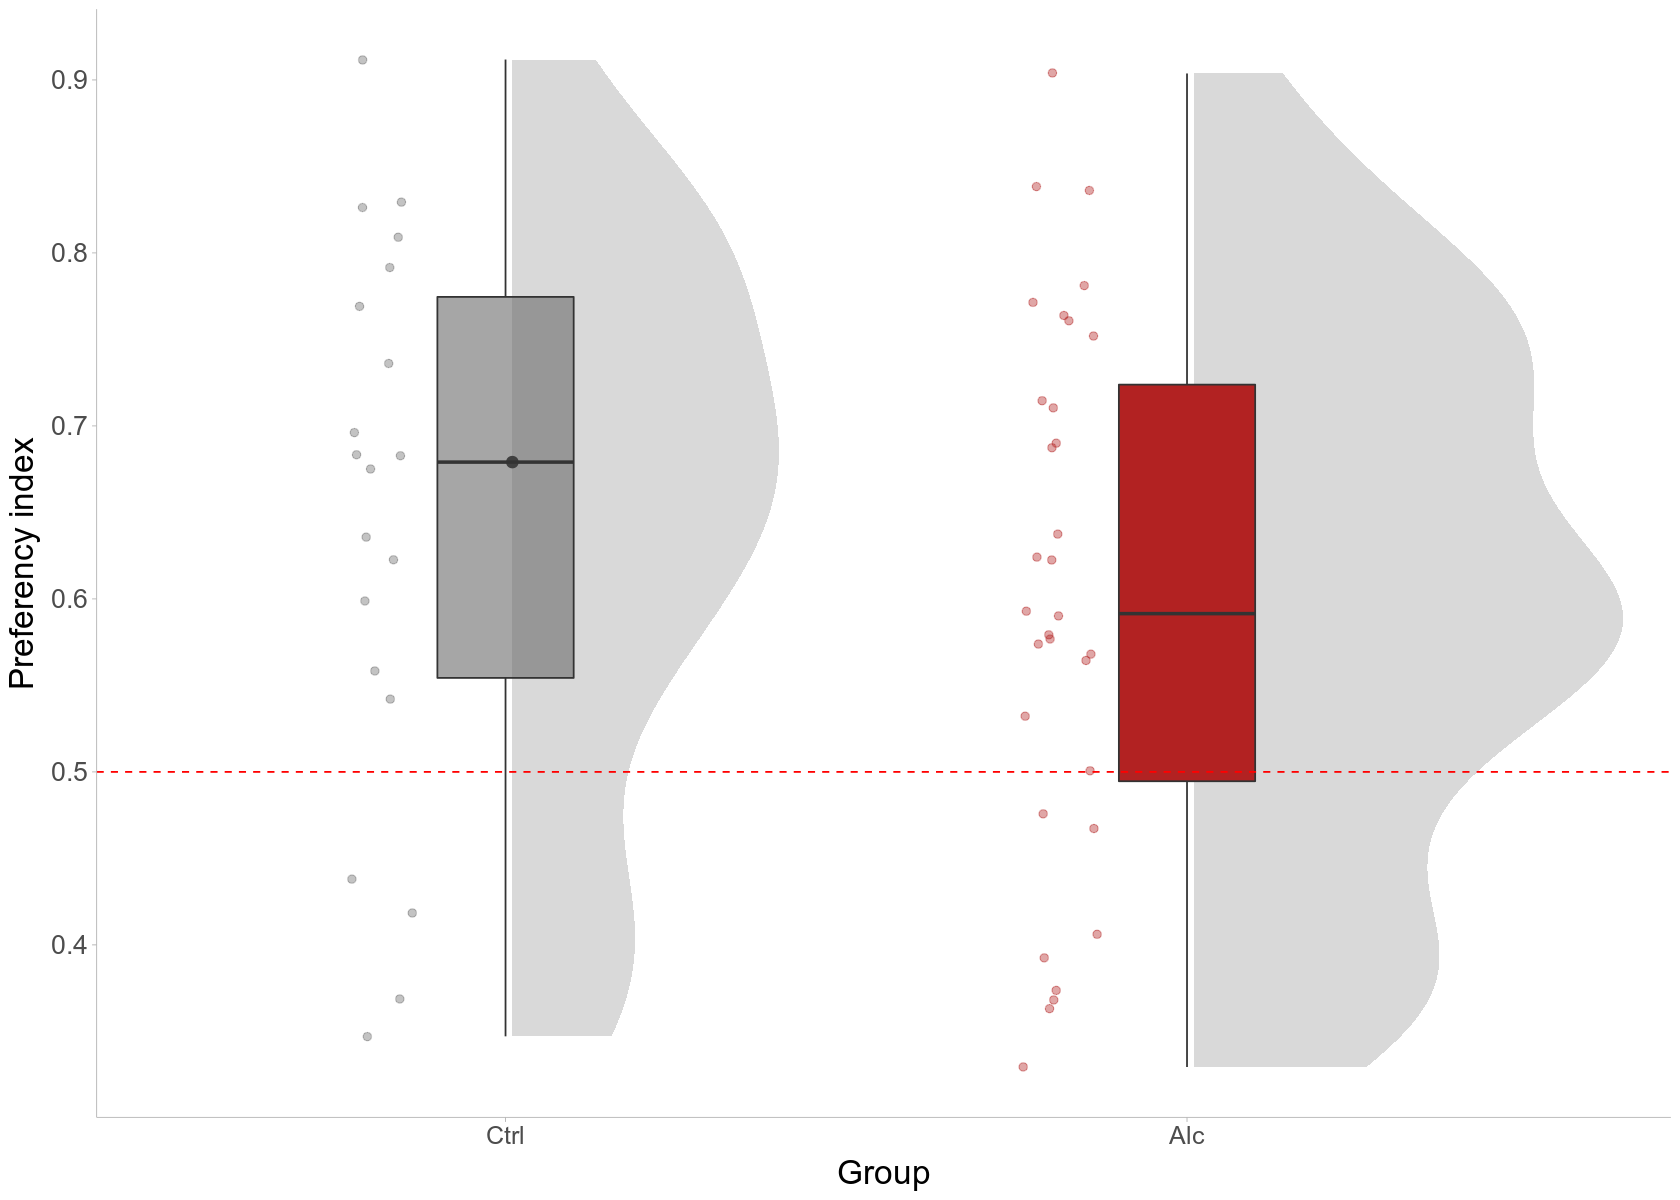

In [47]:
plot_NOR <- NOR_II %>%
  ggplot(aes(x = Group,y = PI, 
             fill = Group)) + 
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = Group),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC, 
  #                               detailed = TRUE)) +
  #stat_compare_means(aes(label = after_stat(p.signif)), 
  #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
  theme_settings
plot_NOR

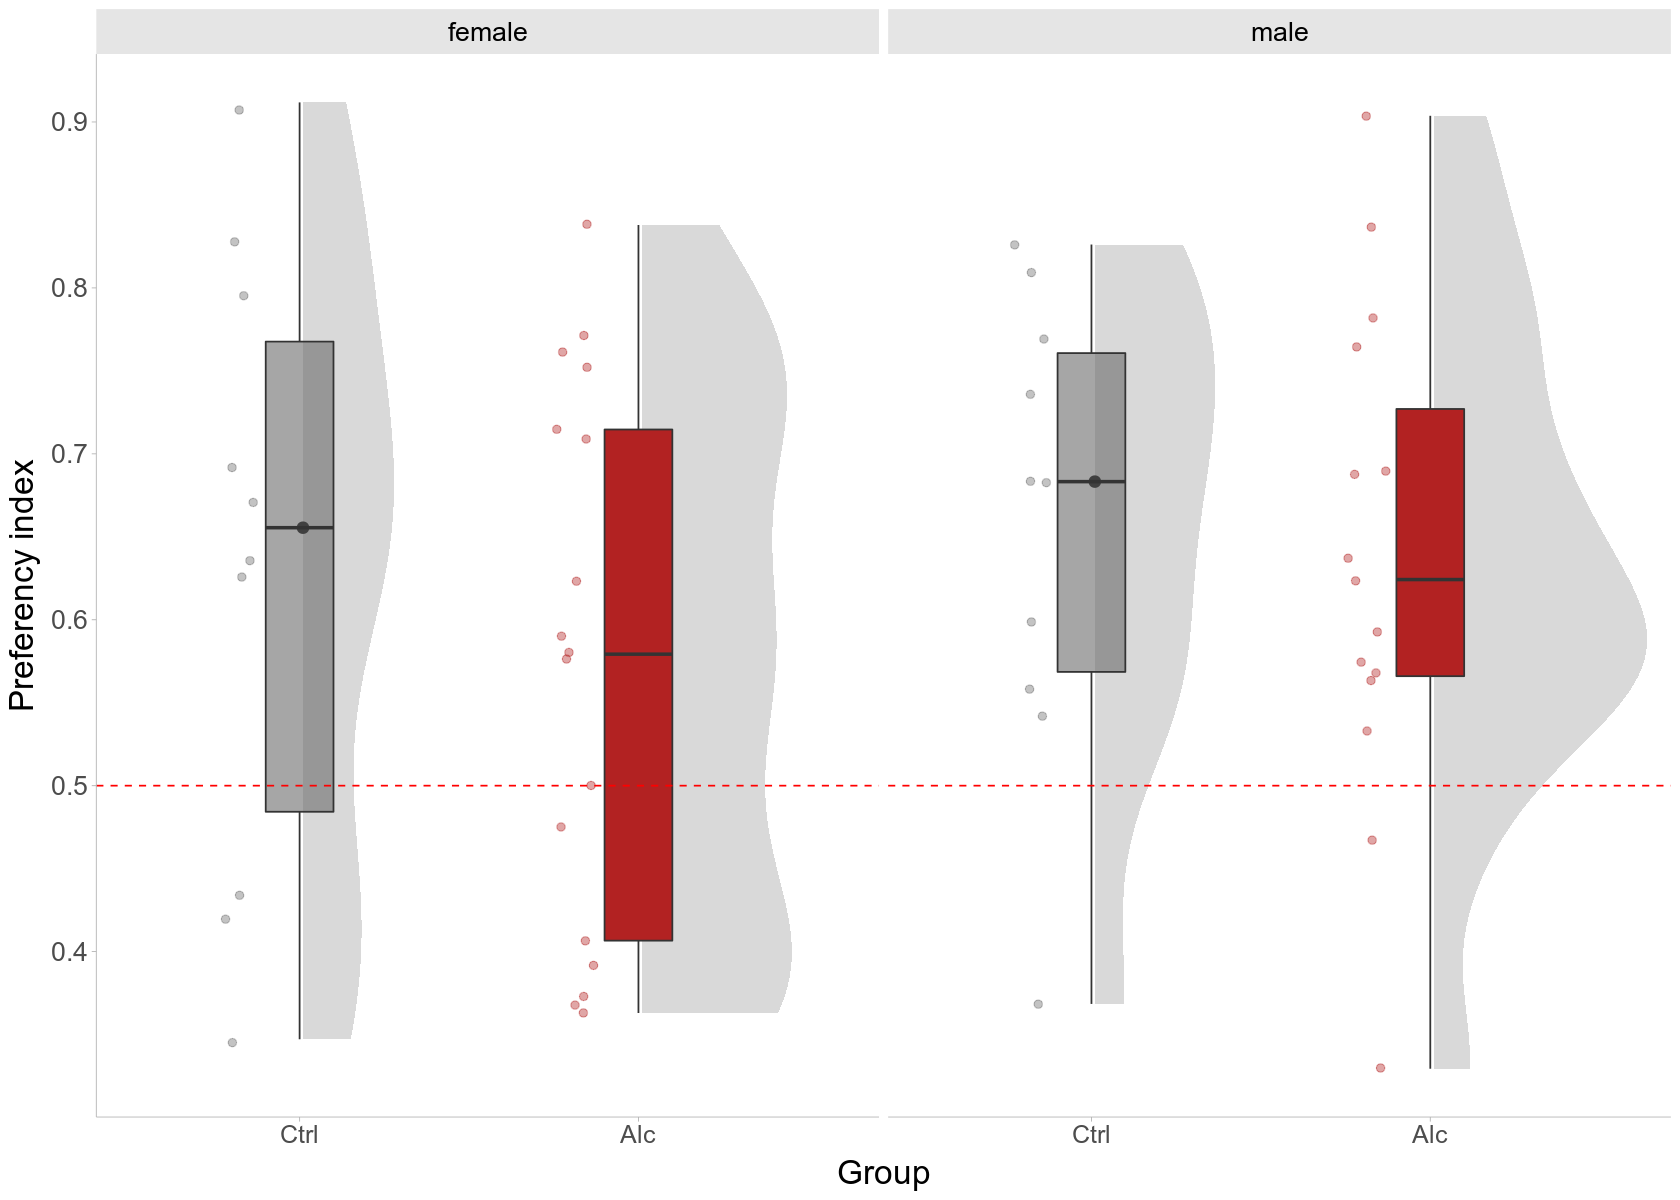

In [48]:
plot_NOR_sex <- NOR_II %>%
  ggplot(aes(x = Group,y = PI, 
             fill = Group)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = Group),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC, 
  #                               detailed = TRUE)) +
  #stat_compare_means(aes(label = after_stat(p.signif)), 
  #                method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") + 
  theme_settings
plot_NOR_sex

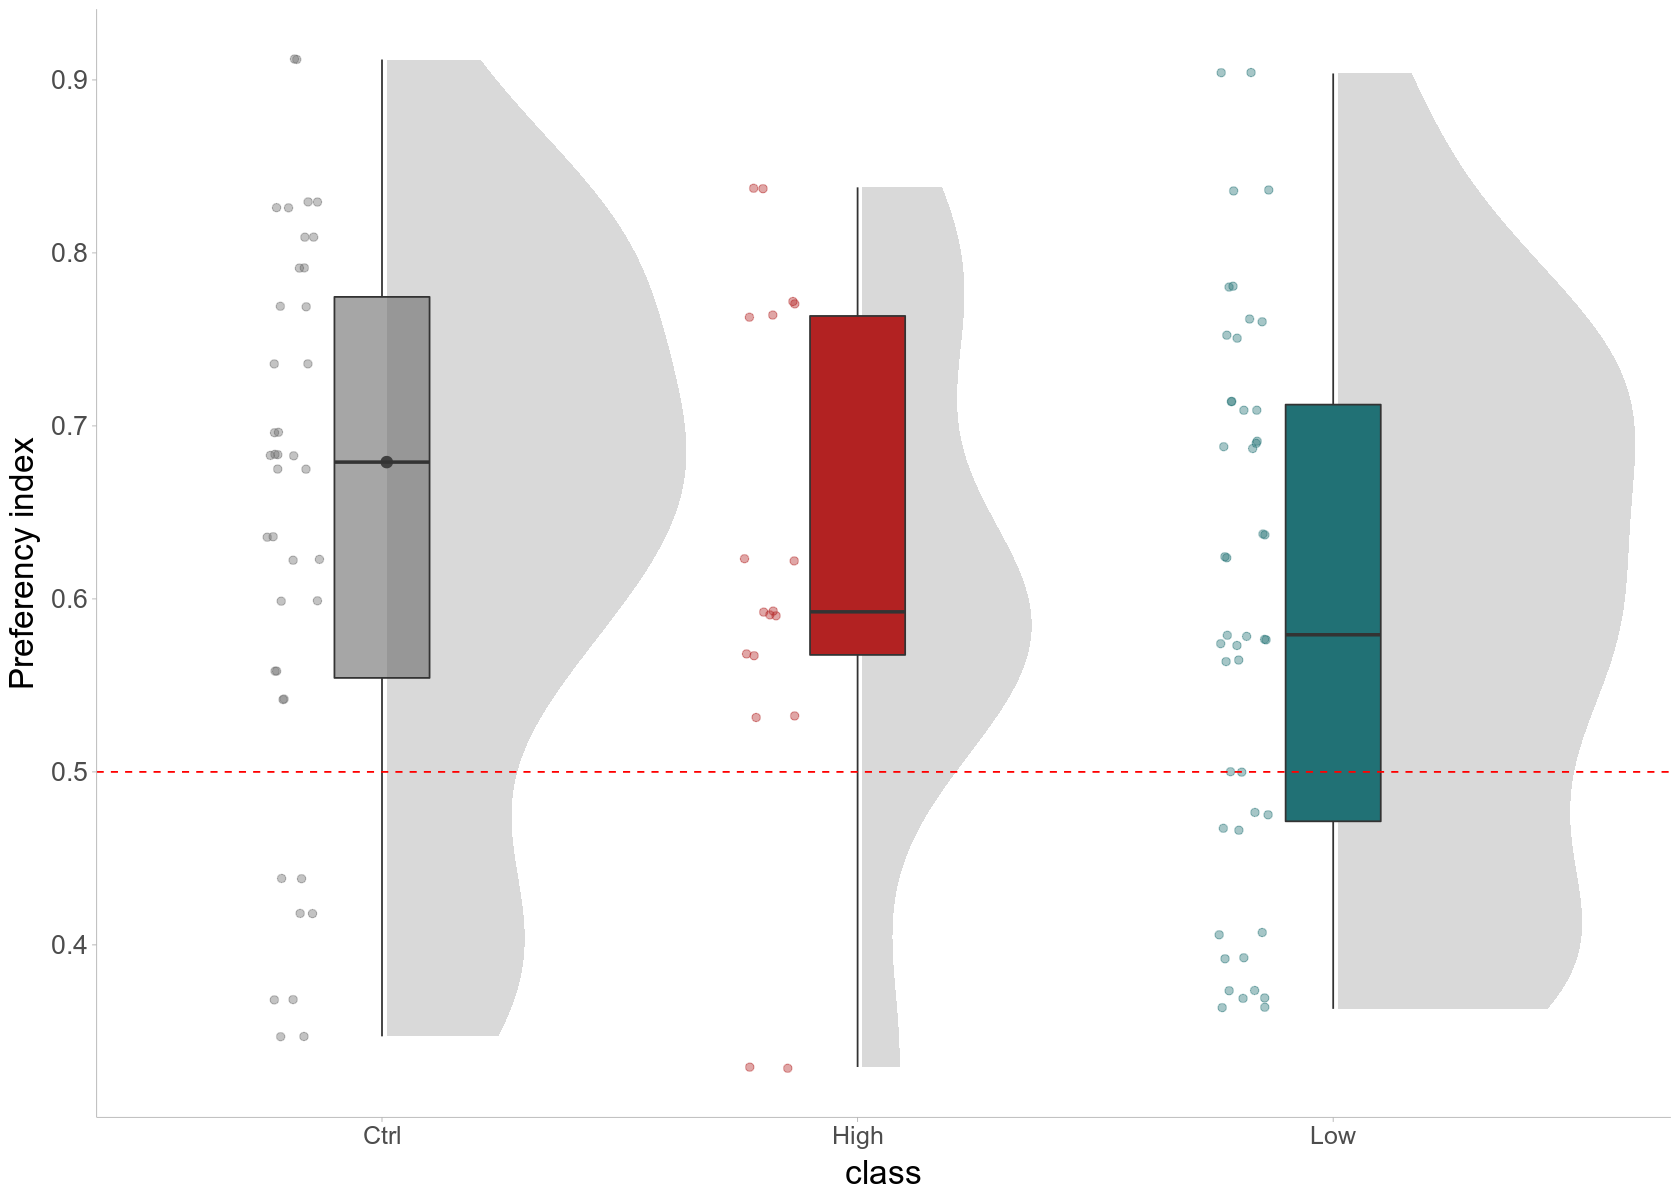

In [49]:
plot_NORClass <- NOR_II %>%
  ggplot(aes(x = class,y = PI, 
             fill = class)) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = class),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) +
  gghalves::geom_half_point(aes(color = class),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  stat_compare_means(aes(label = after_stat(p.signif)), 
                  method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC_class, 
  #                               detailed = TRUE)) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_settings
plot_NORClass

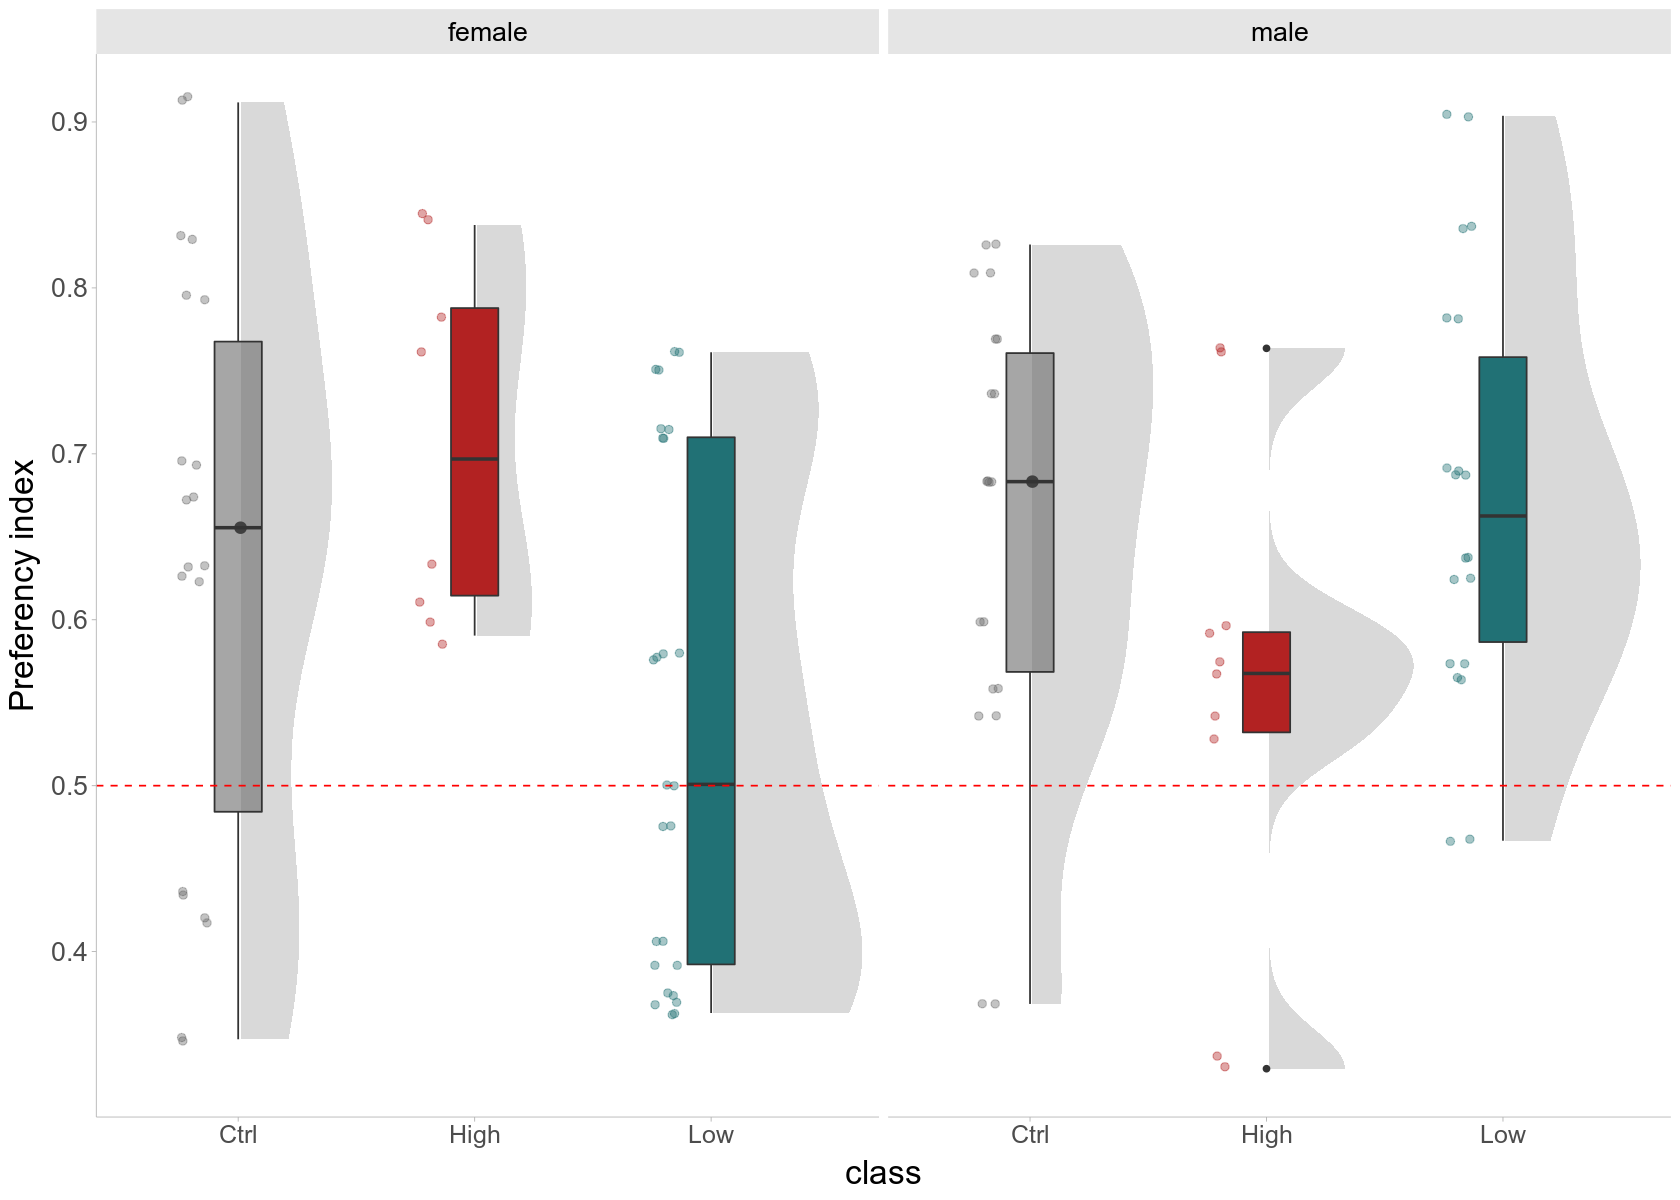

In [50]:
plot_NORClass_sex <- NOR_II %>%
  ggplot(aes(x = class,y = PI, 
             fill = class)) + facet_grid(. ~ Sex) +
  stat_halfeye(
      adjust = .8, width = .7, fill = "grey85",
      interval_colour = NA, 
      position = position_nudge(x = .01),
      aes(thickness = stat(f*n))) +
  gghalves::geom_half_point(aes(color = class),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  geom_boxplot(width = .2) +
  gghalves::geom_half_point(aes(color = class),
                            side = "l", 
                            range_scale = .3, 
                            alpha = .4, size = 2) +
  stat_compare_means(aes(label = after_stat(p.signif)), 
                  method = "t.test", ref.group = "Ctrl", hide.ns = TRUE) + 
  #stat_pvalue_manual(NOR_novel.pwcC,
  #                   tip.length = 0.03, hide.ns = FALSE) +
  #labs(subtitle = get_test_label(NOR_novel.pwcC_class, 
  #                               detailed = TRUE)) +
  ylab("Preferency index") +
  scale_color_manual(values = pal_group) +
  scale_fill_manual(values = pal_group) + 
  theme_ggdist() +
  theme(text = element_text(size = 18), legend.position = "none",
        plot.subtitle = element_text(hjust = 1)) + 
  geom_hline(yintercept=0.5, linetype="dashed", color = "red") +
  theme_settings
plot_NORClass_sex

## **6. Export data**

In [71]:
dir.create("Figures/NOR")

In [72]:
ggsave(plot = plot_NOR, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR.png")

ggsave(plot = plot_NORClass, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR_class.png")

ggsave(plot = plot_NOR_sex, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR_sex.png")

ggsave(plot = plot_NORClass_sex, dpi=300,height = 8, width = 12,bg="white",
       filename = "Figures/NOR/plot_NOR_class_sex.png")

In [73]:
save(NOR_Report_DLC,NOR_timeObj,NOR_entries,NOR_II,plot_NOR,plot_NOR_sex,plot_NORClass_sex, file = paste0(getwd(),"/Data/Behavior_metricsNOR.RData"))